In [1]:
# Import necessary libraries for comprehensive statistical analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Statistical libraries
import scipy.stats as stats
from scipy.stats import (
    pearsonr, spearmanr, kendalltau,
    shapiro, normaltest, jarque_bera,
    mannwhitneyu, kruskal, chi2_contingency,
    f_oneway, ttest_ind, levene
)

# Machine learning and advanced statistics
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score, train_test_split

# Additional statistical tools
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm

import warnings
from pathlib import Path

# Configure display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
warnings.filterwarnings('ignore')

# Set publication-ready plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 16

# Color scheme for years
year_colors = {
    2021: '#E74C3C',  # Red
    2022: '#3498DB',  # Blue  
    2023: '#2ECC71',  # Green
}

print("✅ Libraries loaded successfully!")
print("📊 Statistical analysis environment configured")
print("🎨 Publication-ready plotting style set")

✅ Libraries loaded successfully!
📊 Statistical analysis environment configured
🎨 Publication-ready plotting style set


## 1. Data Loading and Initial Exploration

In [2]:
# Load cleaned data
data_dir = Path('../data')
cleaned_file = data_dir / '2025_09_02_FC_K_A_cleaned.csv'

# Check if cleaned data exists
if not cleaned_file.exists():
    print(f"❌ Cleaned data file not found at {cleaned_file}")
    print("Please run the data cleaning notebook first.")
else:
    df = pd.read_csv(cleaned_file)
    print(f"✅ Data loaded successfully!")
    print(f"Shape: {df.shape}")
    print(f"Columns: {len(df.columns)}")
    print(f"Rows: {len(df)}")
    
    # Create pass/fail indicator if not exists
    if 'passed' not in df.columns and 'final_grade' in df.columns:
        df['passed'] = (df['final_grade'] >= 2).astype(int)
        print("✅ Pass/fail indicator created (grade >= 2)")
    
    # Display basic info about pass/fail distribution
    if 'passed' in df.columns:
        pass_rate = df['passed'].mean() * 100
        print(f"📊 Overall pass rate: {pass_rate:.1f}%")
        print(f"📊 Passed students: {df['passed'].sum()}, Failed students: {(df['passed'] == 0).sum()}")
    
    # Year distribution
    print(f"\n📅 Year distribution:")
    for year in sorted(df['academic_year'].unique()):
        count = len(df[df['academic_year'] == year])
        print(f"  {year}: {count} students ({count/len(df)*100:.1f}%)")

print(f"Features: {df.columns}")

✅ Data loaded successfully!
Shape: (147, 60)
Columns: 60
Rows: 147
📊 Overall pass rate: 55.2%
📊 Passed students: 80.0, Failed students: 65

📅 Year distribution:
  2021: 45 students (30.6%)
  2022: 49 students (33.3%)
  2023: 53 students (36.1%)
Features: Index(['academic_year', 'student_id', 'first_name', 'last_name', 'repeater',
       'test_p4', 'test_p5', 'test_p6', 'test_p7', 'test_p8', 'test_p9',
       'test_p10', 'test_p11', 'test_p12', 'test_p13', 'num_tests_taken',
       'avg_success_rate_per_test', 'percentage_points', 'fc_total_points',
       'team', 'presentation_points', 'defense_points', 'total_defense_points',
       'exam_k2', 'exam_k3', 'exam_k2_k3_total', 'total_continuous',
       'final_grade', 'survey_q1', 'survey_q2', 'survey_q3', 'survey_q4',
       'survey_q5', 'survey_q6', 'survey_q7', 'survey_q8', 'survey_q9',
       'survey_q10', 'survey_q11', 'survey_q12', 'survey_q13', 'survey_q14',
       'survey_q15', 'survey_q16', 'survey_q17', 'survey_q18', 'survey_q1

In [3]:
# Define test variables and create engagement metrics
test_variables = ['test_p4', 'test_p5', 'test_p6', 'test_p7', 'test_p8', 
                 'test_p9', 'test_p10', 'test_p11', 'test_p12', 'test_p13']

print("🧮 Creating Engagement Metrics...")
print("="*50)

# Check which test variables are available
available_tests = [test for test in test_variables if test in df.columns]
missing_tests = [test for test in test_variables if test not in df.columns]

print(f"✅ Available test variables ({len(available_tests)}): {available_tests}")
if missing_tests:
    print(f"⚠️ Missing test variables ({len(missing_tests)}): {missing_tests}")

# Create engagement metrics
if available_tests:
    # 1. Test Participation Rate (proportion of tests attempted)
    df['tests_participation_rate'] = df[available_tests].notna().sum(axis=1) / len(available_tests)
    
    # 2. Test Average Score (mean of attempted tests)
    df['tests_avg_score'] = df[available_tests].mean(axis=1, skipna=True)
    
    # 3. Tests Attempted (absolute count)
    df['tests_attempted'] = df[available_tests].notna().sum(axis=1)
    df['tests_attempted_check'] = df['tests_attempted'] == df['num_tests_taken']
    
    # 4. Test Total Score (sum of all tests, NaN treated as 0)
    df['tests_total_score'] = df[available_tests].fillna(0).sum(axis=1)
    df['fc_total_points_check'] = df['fc_total_points'] == df['tests_total_score']
    
    # 5. Test Engagement Score (combined metric: participation × performance)
    df['tests_engagement_score'] = df['tests_participation_rate'] * df['tests_avg_score'].fillna(0)
    
    # 6. Consistency Score (inverse of coefficient of variation)
    test_std = df[available_tests].std(axis=1, skipna=True)
    test_mean = df[available_tests].mean(axis=1, skipna=True)
    cv = test_std / test_mean
    df['tests_consistency'] = 1 / (1 + cv.fillna(0)) # Lower = more consistent
    
    test_variance = df[available_tests].var(axis=1, skipna=True)
    df['tests_consistency_stability'] = 1 - test_variance.fillna(0)

    mid_point = len(available_tests) // 2
    first_half = available_tests[:mid_point]
    second_half = available_tests[mid_point:]
    
    first_half_mean = df[first_half].mean(axis=1, skipna=True)
    second_half_mean = df[second_half].mean(axis=1, skipna=True)
    
    # Calculate absolute difference (lower = more consistent)
    performance_drift = abs(first_half_mean - second_half_mean)
    df['tests_early_late_consistency'] = 1- (1 / (1 + performance_drift.fillna(0)))
    
    # --- Add percentile features for key engagement metrics ---
    print("\n📊 Calculating Percentiles for Engagement Metrics...")
    
    # Ensure required columns exist
    percentile_metrics = [
        'tests_participation_rate', 
        'tests_attempted',
        'tests_avg_score', 
        'tests_total_score', 
        'tests_engagement_score',
        # 'tests_consistency',
        'tests_consistency_stability',
        'tests_early_late_consistency',
        # 'tests_success_rate',
    ]
    
    for metric in percentile_metrics:
        if metric in df.columns:
            percentile_col = f"{metric}_perct"
            df[percentile_col] = df[metric].rank(pct=True) * 100  # Percentile from 0-100
            print(f"  • {percentile_col} created (mean={df[percentile_col].mean():.2f}, "
                  f"min={df[percentile_col].min():.2f}, max={df[percentile_col].max():.2f})")
        else:
            print(f"  ⚠️ Skipping {metric}, column not found")
            
    print("\n✅ Engagement metrics created:")
    engagement_metrics = percentile_metrics + [
        f"{metric}_perct" for metric in percentile_metrics
    ]
                            
    for metric in engagement_metrics:
        if metric in df.columns:
            print(f"  • {metric}: mean={df[metric].mean():.3f}, std={df[metric].std():.3f}")
else:
    print("❌ No test variables available for analysis")

print(df.columns)
# Define achievement metrics
achievement_metrics = []
if 'final_grade' in df.columns:
    achievement_metrics.append('final_grade')
if 'passed' in df.columns:
    achievement_metrics.append('passed')

print(f"\n🎯 Achievement metrics available: {achievement_metrics}")

df[df['fc_total_points_check'] == False][['first_name', 'last_name', 'fc_total_points_check', 'fc_total_points', 'tests_total_score']]
#df[df['tests_attempted_check'] == False]

🧮 Creating Engagement Metrics...
✅ Available test variables (10): ['test_p4', 'test_p5', 'test_p6', 'test_p7', 'test_p8', 'test_p9', 'test_p10', 'test_p11', 'test_p12', 'test_p13']

📊 Calculating Percentiles for Engagement Metrics...
  • tests_participation_rate_perct created (mean=50.34, min=1.36, max=82.99)
  • tests_attempted_perct created (mean=50.34, min=1.36, max=82.99)
  • tests_avg_score_perct created (mean=50.35, min=1.04, max=100.00)
  • tests_total_score_perct created (mean=50.34, min=2.04, max=100.00)
  • tests_engagement_score_perct created (mean=50.34, min=2.04, max=100.00)
  • tests_consistency_stability_perct created (mean=50.34, min=0.68, max=97.96)
  • tests_early_late_consistency_perct created (mean=50.34, min=8.84, max=100.00)

✅ Engagement metrics created:
  • tests_participation_rate: mean=0.778, std=0.262
  • tests_attempted: mean=7.776, std=2.622
  • tests_avg_score: mean=0.587, std=0.217
  • tests_total_score: mean=4.803, std=2.578
  • tests_engagement_score: m

,first_name,last_name,fc_total_points_check,fc_total_points,tests_total_score
1,Anja,Baić,False,1.66,1.66
6,Mateo,Cerovec,False,2.00,2.01
8,Antonia,Dašek,False,3.36,3.66
16,Petar,Krajačić,False,2.67,2.67
17,Petar,Kramar,False,1.00,0.99
21,Mirjana,Matučec,False,1.67,1.66
23,Marija,Miloš,False,2.67,2.66
24,Lucija,Miloš,False,3.00,4.00
26,Lucija,Musović,False,3.67,3.67
30,Lucija,Peček,False,6.67,6.66


## Distribution Analysis and Statistical Method Selection



['tests_participation_rate', 'tests_attempted', 'tests_avg_score', 'tests_total_score', 'tests_engagement_score', 'tests_consistency_stability', 'tests_early_late_consistency', 'tests_participation_rate_perct', 'tests_attempted_perct', 'tests_avg_score_perct', 'tests_total_score_perct', 'tests_engagement_score_perct', 'tests_consistency_stability_perct', 'tests_early_late_consistency_perct']

📊 Engagement Metrics Distribution Analysis

📊 tests_participation_rate:
  Sample size: 147
  Mean ± SD: 0.778 ± 0.262
  Median: 0.900
  Skewness: -1.324 (Highly skewed)
  Kurtosis: 0.894 (Heavy/Light tails)
  Normality Tests:
    Shapiro-Wilk: p = 0.0000 (Non-normal)
    D'Agostino: p = 0.0000 (Non-normal)
    Jarque-Bera: p = 0.0000 (Non-normal)
  🎯 Recommended: Non-parametric tests (Mann-Whitney, Spearman correlation, Kruskal-Wallis)

📊 tests_attempted:
  Sample size: 147
  Mean ± SD: 7.776 ± 2.622
  Median: 9.000
  Skewness: -1.324 (Highly skewed)
  Kurtosis: 0.894 (Heavy/Light tails)
  Normali

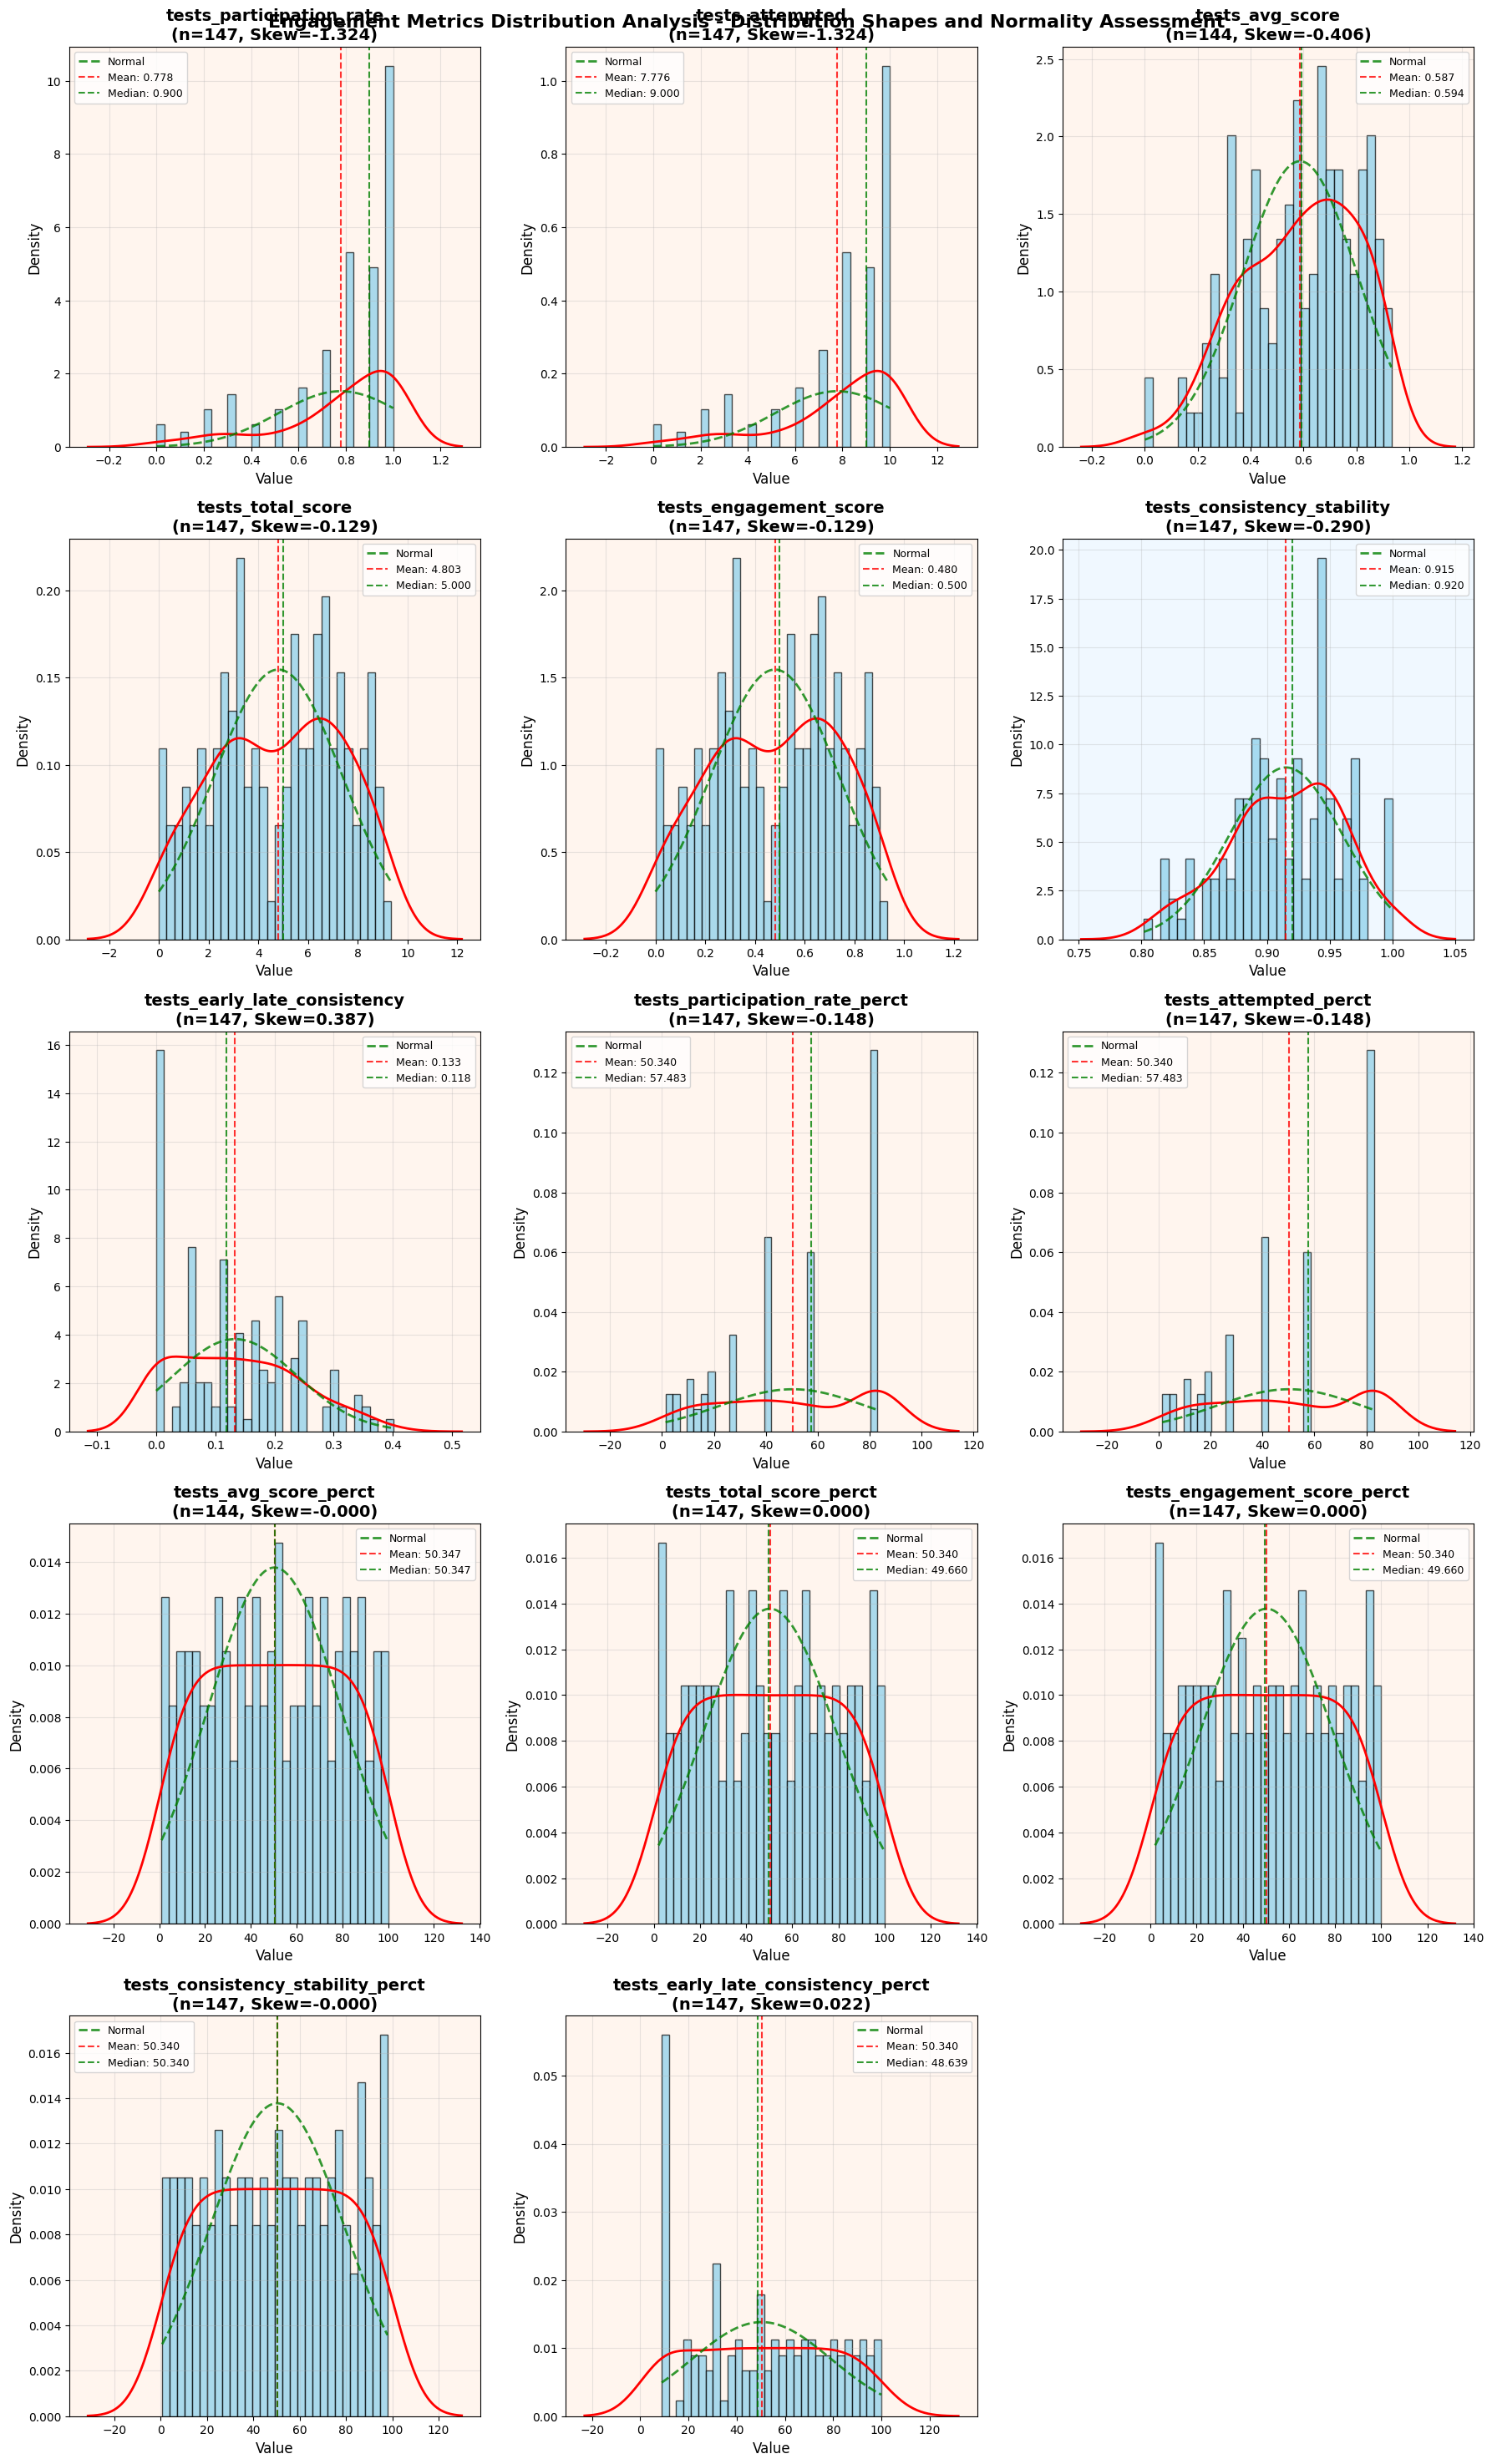


📋 SUMMARY TABLE:
                          Variable   N   Mean    Std  Skewness  Is_Normal Recommended_Method
          tests_participation_rate 147  0.778  0.262    -1.324      False     Non-parametric
                   tests_attempted 147  7.776  2.622    -1.324      False     Non-parametric
                   tests_avg_score 144  0.587  0.217    -0.406      False     Non-parametric
                 tests_total_score 147  4.803  2.578    -0.129      False     Non-parametric
            tests_engagement_score 147  0.480  0.258    -0.129      False     Non-parametric
       tests_consistency_stability 147  0.915  0.045    -0.290       True         Parametric
      tests_early_late_consistency 147  0.133  0.104     0.387      False     Non-parametric
    tests_participation_rate_perct 147 50.340 28.193    -0.148      False     Non-parametric
             tests_attempted_perct 147 50.340 28.193    -0.148      False     Non-parametric
             tests_avg_score_perct 144 50.347 28.964

In [4]:
def comprehensive_distribution_analysis(data, variables, title="Distribution Analysis"):
    """
    Comprehensive distribution analysis with multiple normality tests
    and recommendations for statistical methods
    """
    print(f"\n{'='*80}")
    print(f"📊 {title}")
    print(f"{'='*80}")
    
    results = []
    
    # Create subplots for visualizations
    n_vars = len(variables)
    n_cols = 3
    n_rows = (n_vars + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6 * n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()
    
    for i, var in enumerate(variables):
        if var not in data.columns:
            print(f"⚠️ Variable {var} not found in dataset")
            continue
            
        var_data = data[var].dropna()
        
        if len(var_data) < 3:
            print(f"⚠️ Insufficient data for {var} (n={len(var_data)})")
            continue
        
        # Basic statistics
        mean_val = var_data.mean()
        median_val = var_data.median()
        std_val = var_data.std()
        skewness = stats.skew(var_data)
        kurtosis = stats.kurtosis(var_data)
        
        # Normality tests
        normality_results = {}
        
        # Shapiro-Wilk (best for n < 5000)
        if len(var_data) <= 5000:
            try:
                shapiro_stat, shapiro_p = shapiro(var_data)
                normality_results['Shapiro-Wilk'] = {'stat': shapiro_stat, 'p': shapiro_p}
            except:
                normality_results['Shapiro-Wilk'] = {'stat': np.nan, 'p': np.nan}
        
        # D'Agostino-Pearson (good for larger samples)
        if len(var_data) >= 8:
            try:
                dagostino_stat, dagostino_p = normaltest(var_data)
                normality_results['D\'Agostino'] = {'stat': dagostino_stat, 'p': dagostino_p}
            except:
                normality_results['D\'Agostino'] = {'stat': np.nan, 'p': np.nan}
        
        # Jarque-Bera test
        if len(var_data) >= 7:
            try:
                jb_stat, jb_p = jarque_bera(var_data)
                normality_results['Jarque-Bera'] = {'stat': jb_stat, 'p': jb_p}
            except:
                normality_results['Jarque-Bera'] = {'stat': np.nan, 'p': np.nan}
        
        # Determine if distribution is normal
        p_values = [result['p'] for result in normality_results.values() if not np.isnan(result['p'])]
        is_normal = len(p_values) > 0 and np.mean(p_values) > 0.05
        
        # Visual analysis
        ax = axes[i]
        
        # Histogram with KDE and normal overlay
        ax.hist(var_data, bins=min(30, len(var_data)//3), density=True, alpha=0.7, 
                color='skyblue', edgecolor='black')
        
        # KDE plot
        if std_val > 0:
            try:
                sns.kdeplot(data=var_data, ax=ax, color='red', linewidth=2)
            except:
                pass
        
        # Normal distribution overlay
        if std_val > 0:
            x_norm = np.linspace(var_data.min(), var_data.max(), 100)
            y_norm = stats.norm.pdf(x_norm, mean_val, std_val)
            ax.plot(x_norm, y_norm, 'g--', linewidth=2, alpha=0.8, label='Normal')
        
        # Add vertical lines for mean and median
        ax.axvline(mean_val, color='red', linestyle='--', alpha=0.8, label=f'Mean: {mean_val:.3f}')
        ax.axvline(median_val, color='green', linestyle='--', alpha=0.8, label=f'Median: {median_val:.3f}')
        
        # Formatting
        ax.set_title(f'{var}\n(n={len(var_data)}, Skew={skewness:.3f})', fontweight='bold')
        ax.set_xlabel('Value')
        ax.set_ylabel('Density')
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)
        
        # Color coding for normality
        if is_normal:
            ax.set_facecolor('#f0f8ff')  # Light blue for normal
        else:
            ax.set_facecolor('#fff5ee')  # Light orange for non-normal
        
        # Store results
        result = {
            'Variable': var,
            'N': len(var_data),
            'Mean': mean_val,
            'Median': median_val,
            'Std': std_val,
            'Skewness': skewness,
            'Kurtosis': kurtosis,
            'Is_Normal': is_normal,
            'Recommended_Method': 'Parametric' if is_normal else 'Non-parametric'
        }
        
        # Add normality test results
        for test_name, test_result in normality_results.items():
            result[f'{test_name}_p'] = test_result['p']
        
        results.append(result)
        
        print(f"\n📊 {var}:")
        print(f"  Sample size: {len(var_data)}")
        print(f"  Mean ± SD: {mean_val:.3f} ± {std_val:.3f}")
        print(f"  Median: {median_val:.3f}")
        print(f"  Skewness: {skewness:.3f} ({'Symmetric' if abs(skewness) < 0.5 else 'Moderately skewed' if abs(skewness) < 1 else 'Highly skewed'})")
        print(f"  Kurtosis: {kurtosis:.3f} ({'Normal-like' if abs(kurtosis) < 0.5 else 'Heavy/Light tails'})")
        
        print(f"  Normality Tests:")
        for test_name, test_result in normality_results.items():
            if not np.isnan(test_result['p']):
                significance = "Normal" if test_result['p'] > 0.05 else "Non-normal"
                print(f"    {test_name}: p = {test_result['p']:.4f} ({significance})")
        
        print(f"  🎯 Recommended: {'Parametric tests (t-test, Pearson correlation, ANOVA)' if is_normal else 'Non-parametric tests (Mann-Whitney, Spearman correlation, Kruskal-Wallis)'}")
    
    # Remove empty subplots
    for j in range(len(variables), len(axes)):
        fig.delaxes(axes[j])
    
    plt.suptitle(f'{title} - Distribution Shapes and Normality Assessment', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Summary table
    results_df = pd.DataFrame(results)
    if len(results_df) > 0:
        print(f"\n📋 SUMMARY TABLE:")
        print(f"{'='*80}")
        
        display_cols = ['Variable', 'N', 'Mean', 'Std', 'Skewness', 'Is_Normal', 'Recommended_Method']
        available_cols = [col for col in display_cols if col in results_df.columns]
        
        summary_table = results_df[available_cols].round(3)
        print(summary_table.to_string(index=False))
        
        # Statistical method recommendations
        normal_count = sum(results_df['Is_Normal'])
        total_count = len(results_df)
        
        print(f"\n💡 STATISTICAL METHOD RECOMMENDATIONS:")
        print(f"{'='*60}")
        print(f"Variables with normal distribution: {normal_count}/{total_count} ({normal_count/total_count*100:.1f}%)")
        
        if normal_count >= total_count * 0.8:
            print("🎯 Recommendation: Primarily use PARAMETRIC methods")
            print("  • Pearson correlations")
            print("  • t-tests for group comparisons")
            print("  • ANOVA for multiple groups")
            print("  • Linear regression")
        elif normal_count >= total_count * 0.5:
            print("🎯 Recommendation: Use MIXED approach (both parametric and non-parametric)")
            print("  • Use parametric tests for normal variables")
            print("  • Use non-parametric tests for non-normal variables")
            print("  • Report both Pearson and Spearman correlations")
        else:
            print("🎯 Recommendation: Primarily use NON-PARAMETRIC methods")
            print("  • Spearman correlations")
            print("  • Mann-Whitney U tests for group comparisons")
            print("  • Kruskal-Wallis for multiple groups")
            print("  • Robust regression techniques")
    
    return results_df

print(engagement_metrics)
# Analyze distributions of engagement metrics
if 'engagement_metrics' in locals() and engagement_metrics:
    engagement_dist_results = comprehensive_distribution_analysis(df, engagement_metrics, "Engagement Metrics Distribution Analysis")

['final_grade', 'passed']

📊 Achievement Metrics Distribution Analysis

📊 final_grade:
  Sample size: 145
  Mean ± SD: 2.124 ± 1.130
  Median: 2.000
  Skewness: 0.364 (Symmetric)
  Kurtosis: -1.147 (Heavy/Light tails)
  Normality Tests:
    Shapiro-Wilk: p = 0.0000 (Non-normal)
    D'Agostino: p = 0.0000 (Non-normal)
    Jarque-Bera: p = 0.0038 (Non-normal)
  🎯 Recommended: Non-parametric tests (Mann-Whitney, Spearman correlation, Kruskal-Wallis)

📊 passed:
  Sample size: 145
  Mean ± SD: 0.552 ± 0.499
  Median: 1.000
  Skewness: -0.208 (Symmetric)
  Kurtosis: -1.957 (Heavy/Light tails)
  Normality Tests:
    Shapiro-Wilk: p = 0.0000 (Non-normal)
    D'Agostino: p = 0.0000 (Non-normal)
    Jarque-Bera: p = 0.0000 (Non-normal)
  🎯 Recommended: Non-parametric tests (Mann-Whitney, Spearman correlation, Kruskal-Wallis)


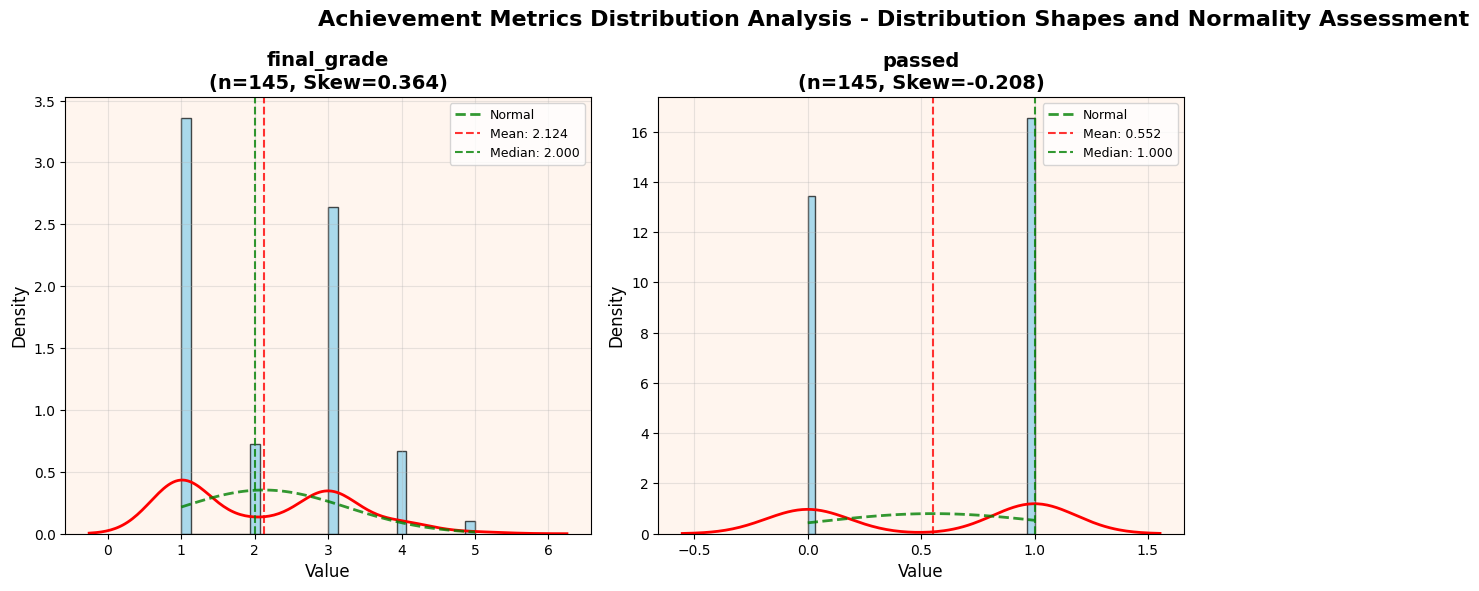


📋 SUMMARY TABLE:
   Variable   N  Mean   Std  Skewness  Is_Normal Recommended_Method
final_grade 145 2.124 1.130     0.364      False     Non-parametric
     passed 145 0.552 0.499    -0.208      False     Non-parametric

💡 STATISTICAL METHOD RECOMMENDATIONS:
Variables with normal distribution: 0/2 (0.0%)
🎯 Recommendation: Primarily use NON-PARAMETRIC methods
  • Spearman correlations
  • Mann-Whitney U tests for group comparisons
  • Kruskal-Wallis for multiple groups
  • Robust regression techniques


In [5]:
print(achievement_metrics)
# Analyze distributions of achievement metrics
if achievement_metrics:
    achievement_dist_results = comprehensive_distribution_analysis(df, achievement_metrics, "Achievement Metrics Distribution Analysis")

## 3. Correlation Analysis: How Strong is the Engagement-Achievement Connection?

['tests_participation_rate', 'tests_attempted', 'tests_avg_score', 'tests_total_score', 'tests_engagement_score', 'tests_consistency_stability', 'tests_early_late_consistency', 'tests_participation_rate_perct', 'tests_attempted_perct', 'tests_avg_score_perct', 'tests_total_score_perct', 'tests_engagement_score_perct', 'tests_consistency_stability_perct', 'tests_early_late_consistency_perct']
['final_grade', 'passed']

🔗 COMPREHENSIVE CORRELATION ANALYSIS
📊 Base engagement metrics: ['tests_participation_rate', 'tests_attempted', 'tests_avg_score', 'tests_total_score', 'tests_engagement_score', 'tests_consistency_stability', 'tests_early_late_consistency']
📊 Percentile engagement metrics: ['tests_participation_rate_perct', 'tests_attempted_perct', 'tests_avg_score_perct', 'tests_total_score_perct', 'tests_engagement_score_perct', 'tests_consistency_stability_perct', 'tests_early_late_consistency_perct']

📊 ANALYZING BASE ENGAGEMENT METRICS


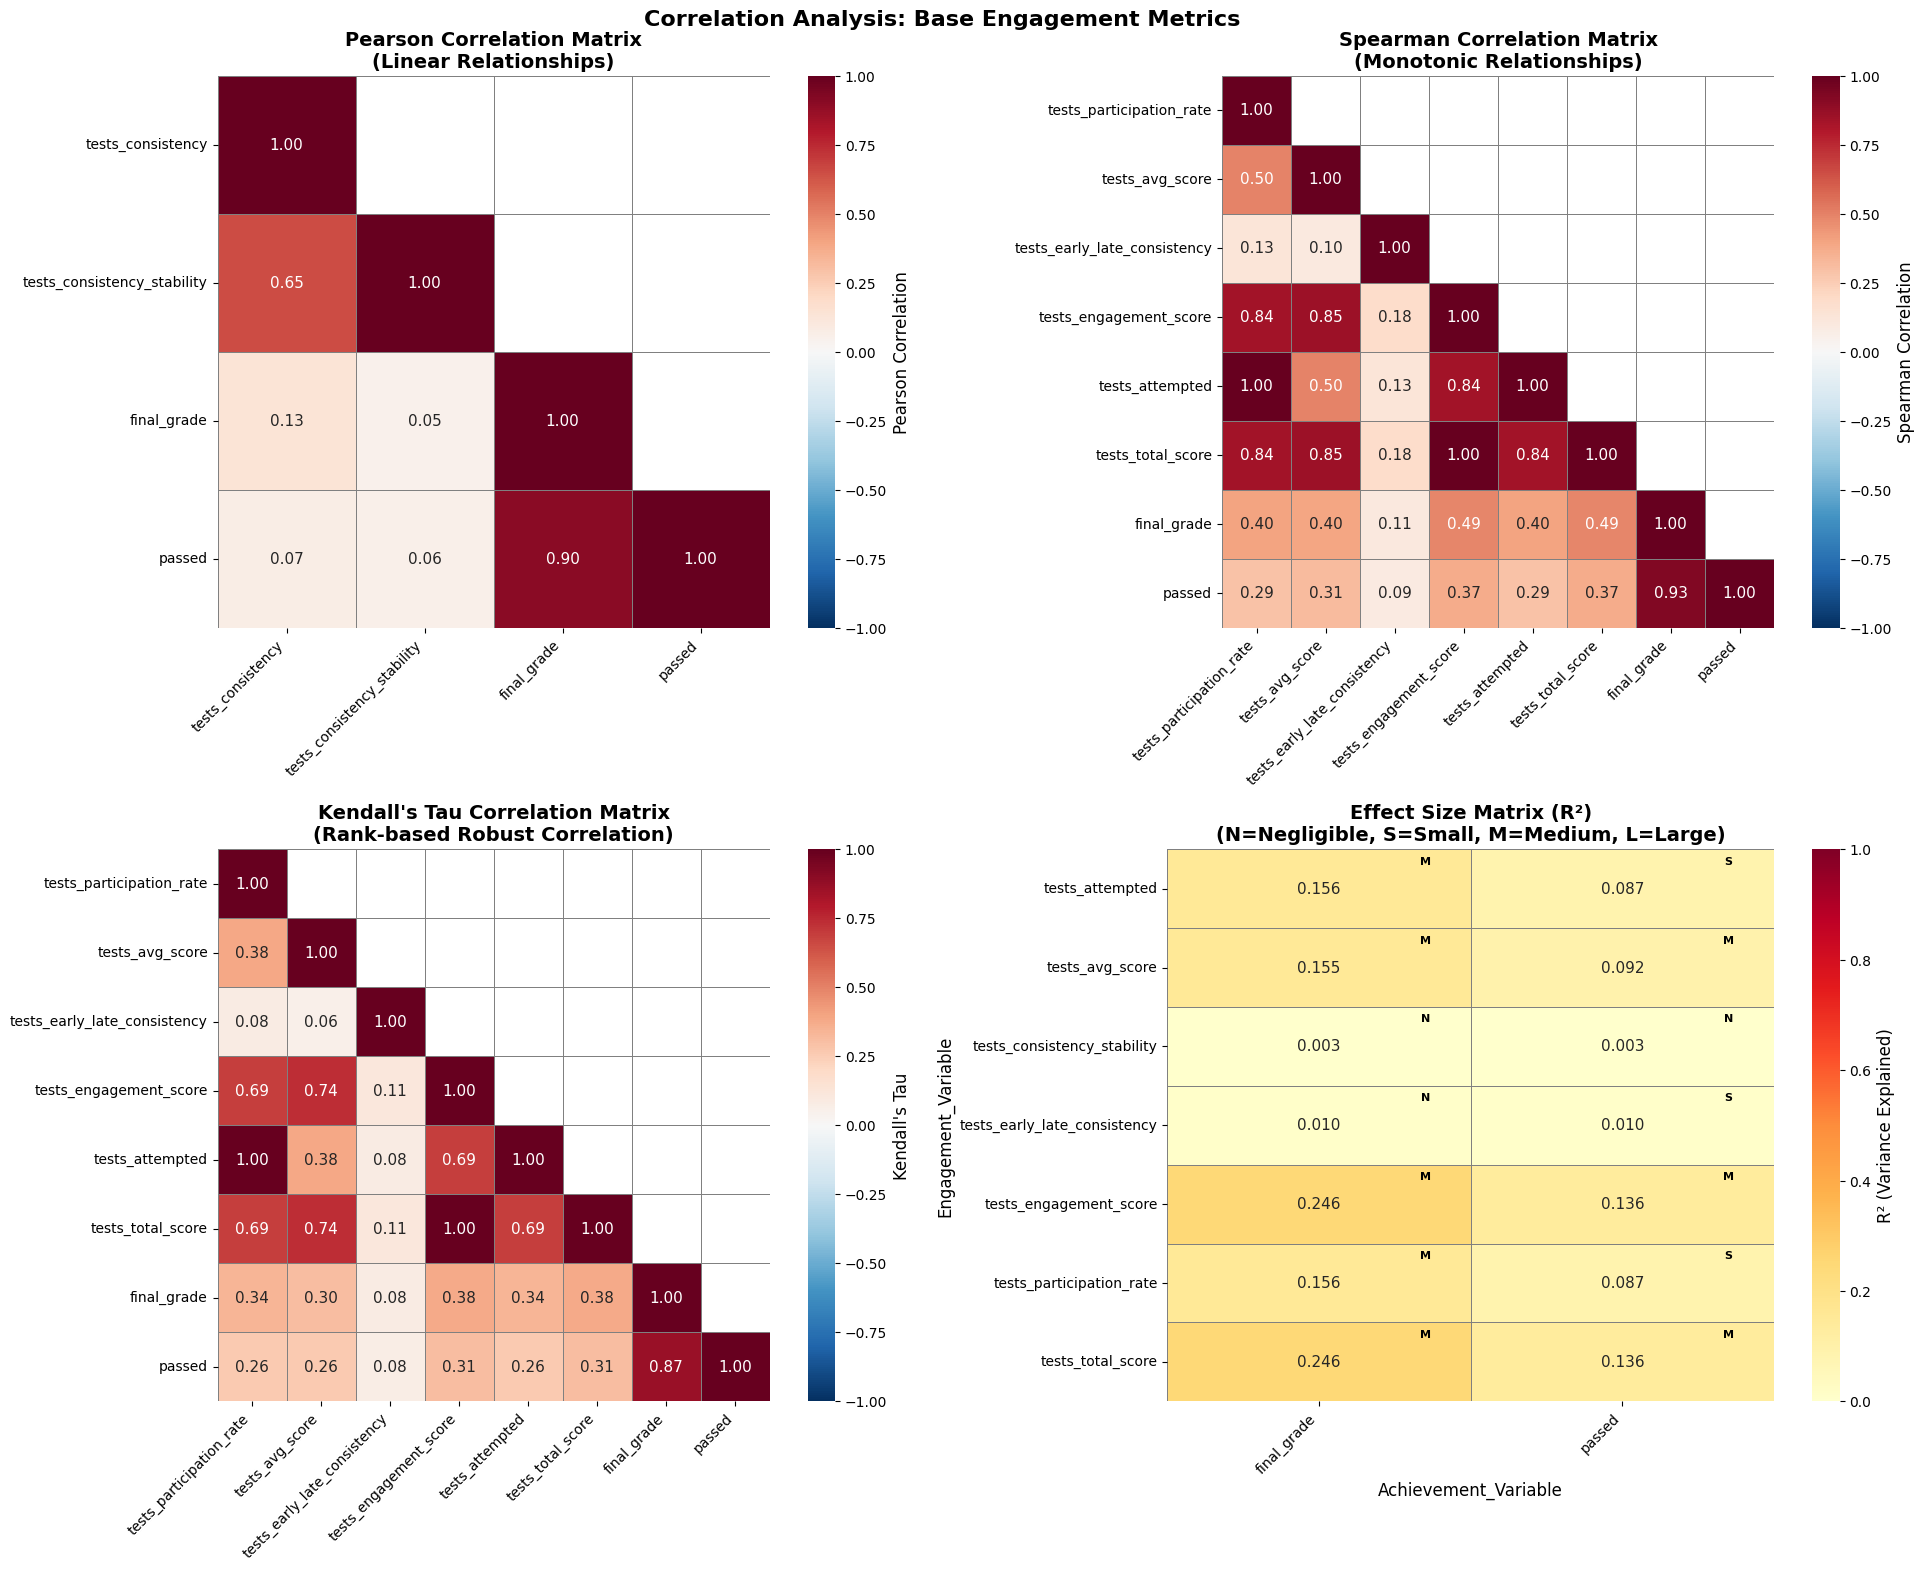


📊 ANALYZING PERCENTILE ENGAGEMENT METRICS


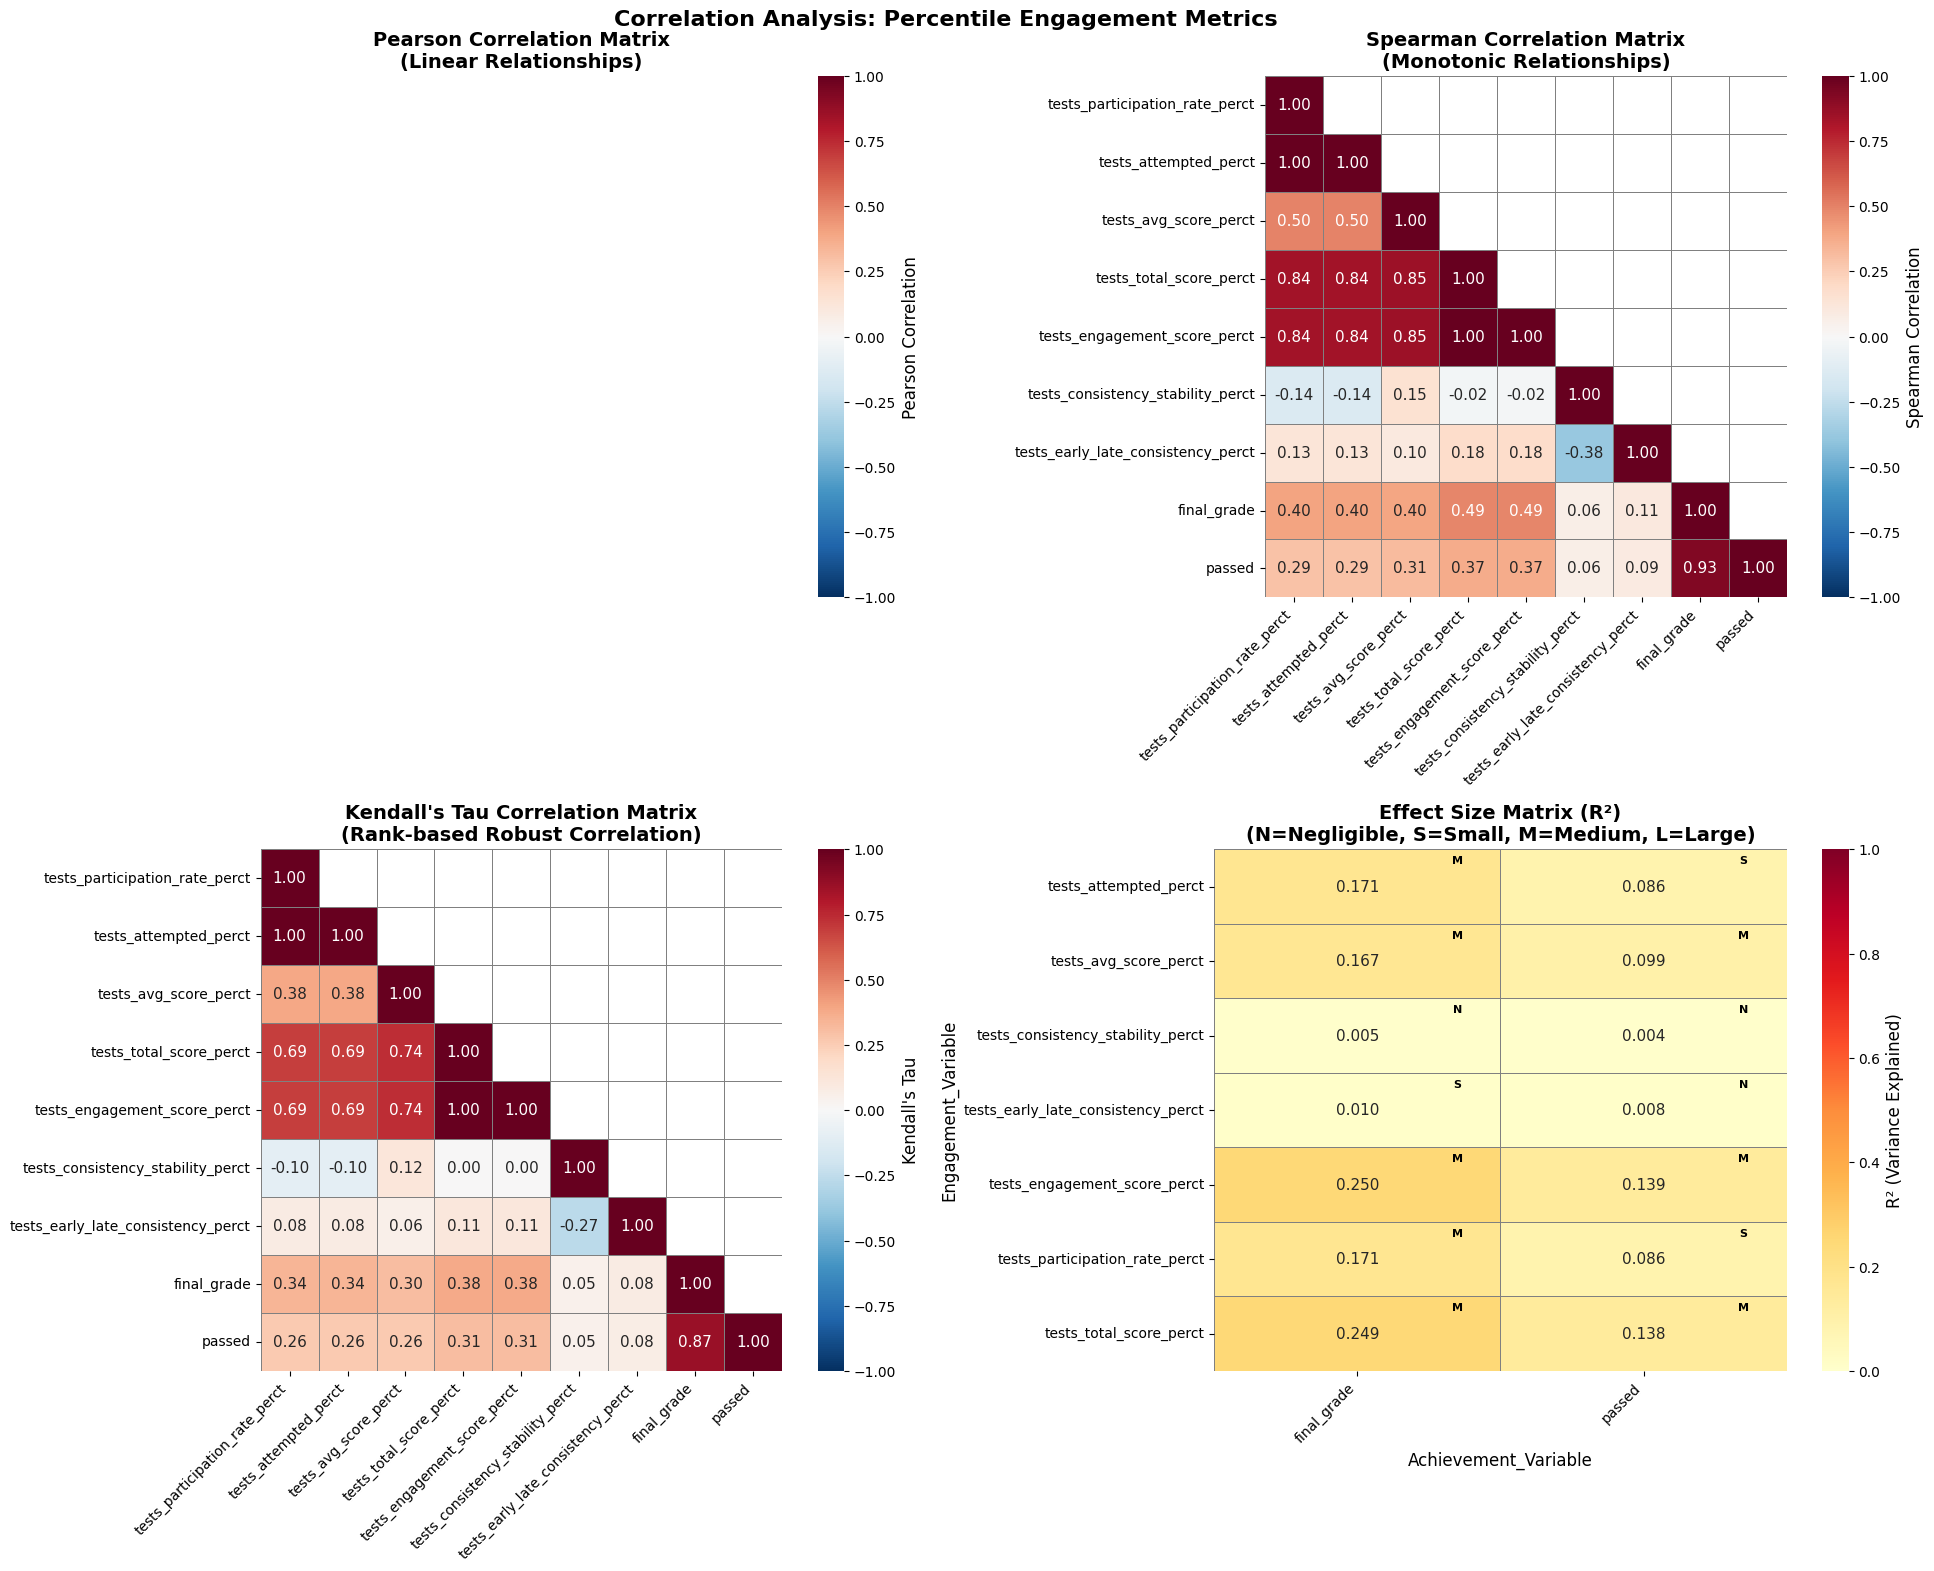


🔍 DETAILED CORRELATION ANALYSIS:

📊 BASE ENGAGEMENT METRICS:

📊 TESTS ATTEMPTED:
--------------------------------------------------
  final_grade (n=145):
    Pearson:  r =  0.394, p = 0.0000 ***
    Spearman: ρ =  0.404, p = 0.0000 ***
    Kendall:  τ =  0.340, p = 0.0000 ***
    Effect size: Medium (r² = 0.156, 15.6% variance explained)
  passed (n=145):
    Pearson:  r =  0.294, p = 0.0003 ***
    Spearman: ρ =  0.294, p = 0.0003 ***
    Kendall:  τ =  0.261, p = 0.0004 ***
    Effect size: Small (r² = 0.087, 8.7% variance explained)

📊 TESTS AVG SCORE:
--------------------------------------------------
  final_grade (n=142):
    Pearson:  r =  0.394, p = 0.0000 ***
    Spearman: ρ =  0.397, p = 0.0000 ***
    Kendall:  τ =  0.305, p = 0.0000 ***
    Effect size: Medium (r² = 0.155, 15.5% variance explained)
  passed (n=142):
    Pearson:  r =  0.303, p = 0.0003 ***
    Spearman: ρ =  0.314, p = 0.0001 ***
    Kendall:  τ =  0.259, p = 0.0002 ***
    Effect size: Medium (r² = 0.092

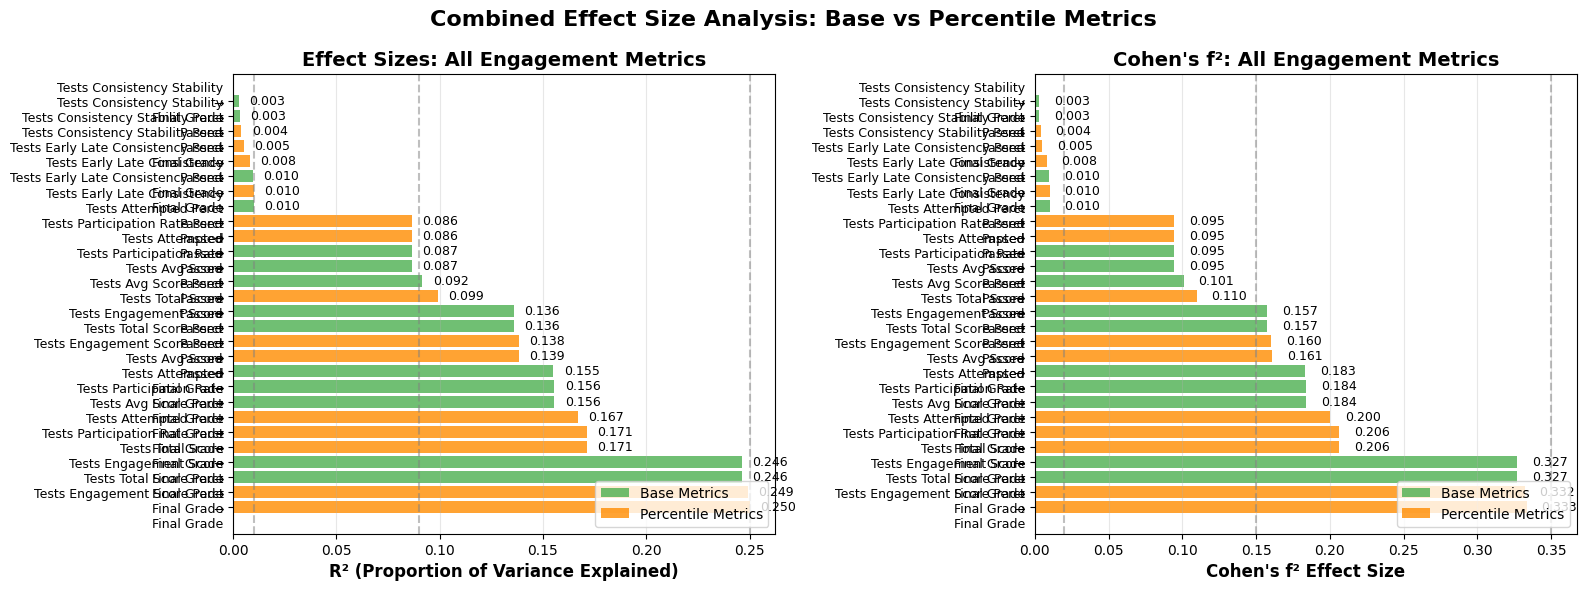


📋 CORRELATION SUMMARY TABLE:
               Engagement_Variable Achievement_Variable   N  Pearson_r  Pearson_p  Spearman_r  Spearman_p  R_squared Effect_Size
          tests_participation_rate          final_grade 145      0.394      0.000       0.404       0.000      0.156      Medium
          tests_participation_rate               passed 145      0.294      0.000       0.294       0.000      0.087       Small
                   tests_attempted          final_grade 145      0.394      0.000       0.404       0.000      0.156      Medium
                   tests_attempted               passed 145      0.294      0.000       0.294       0.000      0.087       Small
                   tests_avg_score          final_grade 142      0.394      0.000       0.397       0.000      0.155      Medium
                   tests_avg_score               passed 142      0.303      0.000       0.314       0.000      0.092      Medium
                 tests_total_score          final_grade 145      0.

In [6]:
def comprehensive_correlation_analysis(data, engagement_vars, achievement_vars):
    """
    Comprehensive correlation analysis with multiple correlation types,
    significance testing, and effect size interpretation - split by percentile metrics
    """
    print(f"\n{'='*80}")
    print(f"🔗 COMPREHENSIVE CORRELATION ANALYSIS")
    print(f"{'='*80}")
    
    correlation_results = []
    
    # Split engagement metrics into base metrics and percentile metrics
    base_engagement_vars = [var for var in engagement_vars if var in data.columns and not var.endswith('_perct')]
    perct_engagement_vars = [var for var in engagement_vars if var in data.columns and var.endswith('_perct')]
    
    print(f"📊 Base engagement metrics: {base_engagement_vars}")
    print(f"📊 Percentile engagement metrics: {perct_engagement_vars}")
    
    # Function to create correlation plots for a set of variables
    def create_correlation_plots(engagement_vars_subset, title_suffix):
        # Create correlation matrix for visualization
        all_vars = engagement_vars_subset + achievement_vars
        available_vars = [var for var in all_vars if var in data.columns]
        
        if len(available_vars) < 2:
            print(f"❌ Insufficient variables for {title_suffix} correlation analysis")
            return None

        outs = ['final_grade', 'passed']
        if not engagement_vars_subset[0].endswith("_perct"):
            pearson_vars = ['tests_consistency', 'tests_consistency_stability'] + outs
            spearman_vars = list(set(available_vars) - set(pearson_vars)) + outs
        else:
            pearson_vars = []
            spearman_vars = available_vars
        
        # Calculate different types of correlations
        pearson_corr = data[pearson_vars].corr(method='pearson')
        spearman_corr = data[spearman_vars].corr(method='spearman')
        kendall_corr = data[spearman_vars].corr(method='kendall')
        
        # Create comprehensive correlation heatmaps - all three types
        fig, axes = plt.subplots(2, 2, figsize=(20, 16))
        
        # 1. Pearson correlation heatmap
        mask1 = np.triu(np.ones_like(pearson_corr, dtype=bool), k=1)
        sns.heatmap(pearson_corr, annot=True, cmap='RdBu_r', center=0, 
                    square=True, mask=mask1, ax=axes[0,0], fmt='.2f',
                    cbar_kws={'label': 'Pearson Correlation'},
                    vmin=-1, vmax=1, linewidths=0.5, linecolor='gray')
        axes[0,0].set_title('Pearson Correlation Matrix\n(Linear Relationships)', 
                           fontsize=14, fontweight='bold')
        axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(), rotation=45, ha='right')
        axes[0,0].set_yticklabels(axes[0,0].get_yticklabels(), rotation=0)
        
        # 2. Spearman correlation heatmap
        mask2 = np.triu(np.ones_like(spearman_corr, dtype=bool), k=1)
        sns.heatmap(spearman_corr, annot=True, cmap='RdBu_r', center=0, 
                    square=True, mask=mask2, ax=axes[0,1], fmt='.2f',
                    cbar_kws={'label': 'Spearman Correlation'},
                    vmin=-1, vmax=1, linewidths=0.5, linecolor='gray')
        axes[0,1].set_title('Spearman Correlation Matrix\n(Monotonic Relationships)', 
                           fontsize=14, fontweight='bold')
        axes[0,1].set_xticklabels(axes[0,1].get_xticklabels(), rotation=45, ha='right')
        axes[0,1].set_yticklabels(axes[0,1].get_yticklabels(), rotation=0)
        
        # 3. Kendall's Tau correlation heatmap
        mask3 = np.triu(np.ones_like(kendall_corr, dtype=bool), k=1)
        sns.heatmap(kendall_corr, annot=True, cmap='RdBu_r', center=0, 
                    square=True, mask=mask3, ax=axes[1,0], fmt='.2f',
                    cbar_kws={'label': "Kendall's Tau"},
                    vmin=-1, vmax=1, linewidths=0.5, linecolor='gray')
        axes[1,0].set_title("Kendall's Tau Correlation Matrix\n(Rank-based Robust Correlation)", 
                           fontsize=14, fontweight='bold')
        axes[1,0].set_xticklabels(axes[1,0].get_xticklabels(), rotation=45, ha='right')
        axes[1,0].set_yticklabels(axes[1,0].get_yticklabels(), rotation=0)
        
        # 4. Effect Size Visualization (R² heatmap)
        # Calculate correlations and store results for this subset
        subset_results = []
        
        for eng_var in engagement_vars_subset:
            if eng_var not in data.columns:
                continue
                
            for ach_var in achievement_vars:
                if ach_var not in data.columns:
                    continue
                
                # Get clean data
                clean_data_subset = data[[eng_var, ach_var]].dropna()
                
                if len(clean_data_subset) < 3:
                    continue
                
                # Calculate correlations with significance tests
                try:
                    # Pearson correlation
                    r_pearson, p_pearson = pearsonr(clean_data_subset[eng_var], clean_data_subset[ach_var])
                    
                    # Spearman correlation
                    r_spearman, p_spearman = spearmanr(clean_data_subset[eng_var], clean_data_subset[ach_var])
                    
                    # Kendall tau (robust rank correlation)
                    r_kendall, p_kendall = kendalltau(clean_data_subset[eng_var], clean_data_subset[ach_var])
                    
                    # Effect size interpretation
                    def interpret_correlation(r):
                        abs_r = abs(r)
                        if abs_r < 0.1:
                            return "Negligible"
                        elif abs_r < 0.3:
                            return "Small"
                        elif abs_r < 0.5:
                            return "Medium"
                        elif abs_r < 0.7:
                            return "Large"
                        else:
                            return "Very Large"
                    
                    # Variance explained (R²)
                    r_squared = r_pearson ** 2
                    
                    # Store results for summary
                    subset_results.append({
                        'Engagement_Variable': eng_var,
                        'Achievement_Variable': ach_var,
                        'N': len(clean_data_subset),
                        'Pearson_r': r_pearson,
                        'Pearson_p': p_pearson,
                        'Spearman_r': r_spearman,
                        'Spearman_p': p_spearman,
                        'Kendall_r': r_kendall,
                        'Kendall_p': p_kendall,
                        'R_squared': r_squared,
                        'Effect_Size': interpret_correlation(r_pearson)
                    })
                    
                except Exception as e:
                    continue
        
        if subset_results:
            # Create R² matrix for effect size visualization
            corr_df = pd.DataFrame(subset_results)
            
            # Create pivot table for R² values
            r_squared_matrix = pd.pivot_table(
                corr_df, 
                values='R_squared', 
                index='Engagement_Variable',
                columns='Achievement_Variable',
                aggfunc='mean'
            )
            
            # Plot R² heatmap (effect size visualization)
            ax = axes[1,1]
            
            # Create custom colormap for effect sizes
            sns.heatmap(r_squared_matrix, annot=True, cmap='YlOrRd', 
                        square=False, ax=ax, fmt='.3f',
                        cbar_kws={'label': 'R² (Variance Explained)'},
                        vmin=0, vmax=1, linewidths=0.5, linecolor='gray')
            
            # Add effect size interpretation as text
            for i, eng_var in enumerate(r_squared_matrix.index):
                for j, ach_var in enumerate(r_squared_matrix.columns):
                    r_sq = r_squared_matrix.iloc[i, j]
                    if pd.notna(r_sq):
                        # Determine effect size category
                        if r_sq < 0.01:
                            effect_text = 'N'  # Negligible
                        elif r_sq < 0.09:
                            effect_text = 'S'  # Small
                        elif r_sq < 0.25:
                            effect_text = 'M'  # Medium
                        else:
                            effect_text = 'L'  # Large
                        
                        # Add small text indicator in corner
                        ax.text(j + 0.85, i + 0.15, effect_text, 
                               fontsize=8, fontweight='bold', 
                               color='white' if r_sq > 0.5 else 'black',
                               ha='center', va='center')
            
            ax.set_title('Effect Size Matrix (R²)\n(N=Negligible, S=Small, M=Medium, L=Large)', 
                        fontsize=14, fontweight='bold')
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
            ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
        
        plt.suptitle(f'Correlation Analysis: {title_suffix}', 
                     fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        return subset_results
    
    # Create plots for base engagement metrics
    if base_engagement_vars:
        print(f"\n{'='*60}")
        print(f"📊 ANALYZING BASE ENGAGEMENT METRICS")
        print(f"{'='*60}")
        
        base_results = create_correlation_plots(base_engagement_vars, "Base Engagement Metrics")
        if base_results:
            correlation_results.extend(base_results)
    
    # Create plots for percentile engagement metrics
    if perct_engagement_vars:
        print(f"\n{'='*60}")
        print(f"📊 ANALYZING PERCENTILE ENGAGEMENT METRICS")
        print(f"{'='*60}")
        
        perct_results = create_correlation_plots(perct_engagement_vars, "Percentile Engagement Metrics")
        if perct_results:
            correlation_results.extend(perct_results)
    
    # Detailed correlation analysis (text output)
    print(f"\n🔍 DETAILED CORRELATION ANALYSIS:")
    print("="*60)
    
    # Analyze base metrics first
    if base_engagement_vars:
        print(f"\n📊 BASE ENGAGEMENT METRICS:")
        print("="*50)
        
        for eng_var in sorted(base_engagement_vars):  # Sort consistently
            if eng_var not in data.columns:
                continue
                
            print(f"\n📊 {eng_var.upper().replace('_', ' ')}:")
            print("-" * 50)
            
            for ach_var in achievement_vars:
                if ach_var not in data.columns:
                    continue
                
                # Get clean data
                clean_data = data[[eng_var, ach_var]].dropna()
                
                if len(clean_data) < 3:
                    print(f"  {ach_var}: Insufficient data (n={len(clean_data)})")
                    continue
                
                # Calculate correlations with significance tests
                try:
                    # Pearson correlation
                    r_pearson, p_pearson = pearsonr(clean_data[eng_var], clean_data[ach_var])
                    
                    # Spearman correlation
                    r_spearman, p_spearman = spearmanr(clean_data[eng_var], clean_data[ach_var])
                    
                    # Kendall tau (robust rank correlation)
                    r_kendall, p_kendall = kendalltau(clean_data[eng_var], clean_data[ach_var])
                    
                    # Variance explained (R²)
                    r_squared = r_pearson ** 2
                    
                    print(f"  {ach_var} (n={len(clean_data)}):")
                    print(f"    Pearson:  r = {r_pearson:6.3f}, p = {p_pearson:.4f} {'***' if p_pearson < 0.001 else '**' if p_pearson < 0.01 else '*' if p_pearson < 0.05 else 'ns'}")
                    print(f"    Spearman: ρ = {r_spearman:6.3f}, p = {p_spearman:.4f} {'***' if p_spearman < 0.001 else '**' if p_spearman < 0.01 else '*' if p_spearman < 0.05 else 'ns'}")
                    print(f"    Kendall:  τ = {r_kendall:6.3f}, p = {p_kendall:.4f} {'***' if p_kendall < 0.001 else '**' if p_kendall < 0.01 else '*' if p_kendall < 0.05 else 'ns'}")
                    
                    # Effect size interpretation
                    def interpret_correlation(r):
                        abs_r = abs(r)
                        if abs_r < 0.1:
                            return "Negligible"
                        elif abs_r < 0.3:
                            return "Small"
                        elif abs_r < 0.5:
                            return "Medium"
                        elif abs_r < 0.7:
                            return "Large"
                        else:
                            return "Very Large"
                    
                    print(f"    Effect size: {interpret_correlation(r_pearson)} (r² = {r_squared:.3f}, {r_squared*100:.1f}% variance explained)")
                    
                except Exception as e:
                    print(f"  {ach_var}: Error calculating correlations - {str(e)}")
    
    # Analyze percentile metrics
    if perct_engagement_vars:
        print(f"\n📊 PERCENTILE ENGAGEMENT METRICS:")
        print("="*50)
        
        for eng_var in sorted(perct_engagement_vars):  # Sort consistently
            if eng_var not in data.columns:
                continue
                
            print(f"\n📊 {eng_var.upper().replace('_', ' ')}:")
            print("-" * 50)
            
            for ach_var in achievement_vars:
                if ach_var not in data.columns:
                    continue
                
                # Get clean data
                clean_data = data[[eng_var, ach_var]].dropna()
                
                if len(clean_data) < 3:
                    print(f"  {ach_var}: Insufficient data (n={len(clean_data)})")
                    continue
                
                # Calculate correlations with significance tests
                try:
                    # Pearson correlation
                    r_pearson, p_pearson = pearsonr(clean_data[eng_var], clean_data[ach_var])
                    
                    # Spearman correlation
                    r_spearman, p_spearman = spearmanr(clean_data[eng_var], clean_data[ach_var])
                    
                    # Kendall tau (robust rank correlation)
                    r_kendall, p_kendall = kendalltau(clean_data[eng_var], clean_data[ach_var])
                    
                    # Variance explained (R²)
                    r_squared = r_pearson ** 2
                    
                    print(f"  {ach_var} (n={len(clean_data)}):")
                    print(f"    Pearson:  r = {r_pearson:6.3f}, p = {p_pearson:.4f} {'***' if p_pearson < 0.001 else '**' if p_pearson < 0.01 else '*' if p_pearson < 0.05 else 'ns'}")
                    print(f"    Spearman: ρ = {r_spearman:6.3f}, p = {p_spearman:.4f} {'***' if p_spearman < 0.001 else '**' if p_spearman < 0.01 else '*' if p_spearman < 0.05 else 'ns'}")
                    print(f"    Kendall:  τ = {r_kendall:6.3f}, p = {p_kendall:.4f} {'***' if p_kendall < 0.001 else '**' if p_kendall < 0.01 else '*' if p_kendall < 0.05 else 'ns'}")
                    print(f"    Effect size: {interpret_correlation(r_pearson)} (r² = {r_squared:.3f}, {r_squared*100:.1f}% variance explained)")
                    
                except Exception as e:
                    print(f"  {ach_var}: Error calculating correlations - {str(e)}")
    
    # Additional Effect Size Visualization - Bar chart (combined)
    if correlation_results:
        # Create a separate figure for effect size comparison
        fig2, axes2 = plt.subplots(1, 2, figsize=(16, 6))
        
        # Sort by R² for better visualization
        corr_df = pd.DataFrame(correlation_results)
        corr_df_sorted = corr_df.sort_values('R_squared', ascending=False)
        
        # Create labels for each correlation
        corr_df_sorted['Pair'] = corr_df_sorted['Engagement_Variable'].str.replace('_', ' ').str.title() + '\n→\n' + \
                                 corr_df_sorted['Achievement_Variable'].str.replace('_', ' ').str.title()
        
        # Color by metric type
        colors = []
        for var in corr_df_sorted['Engagement_Variable']:
            if var.endswith('_perct'):
                colors.append('#ff8c00')  # Orange for percentile metrics
            else:
                colors.append('#4CAF50')  # Green for base metrics
        
        # 1. R² Bar Chart
        ax1 = axes2[0]
        bars = ax1.barh(range(len(corr_df_sorted)), corr_df_sorted['R_squared'], color=colors, alpha=0.8)
        
        ax1.set_yticks(range(len(corr_df_sorted)))
        ax1.set_yticklabels(corr_df_sorted['Pair'], fontsize=9)
        ax1.set_xlabel('R² (Proportion of Variance Explained)', fontweight='bold')
        ax1.set_title('Effect Sizes: All Engagement Metrics', fontweight='bold')
        ax1.grid(True, alpha=0.3, axis='x')
        
        # Add legend for colors
        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor='#4CAF50', alpha=0.8, label='Base Metrics'),
                          Patch(facecolor='#ff8c00', alpha=0.8, label='Percentile Metrics')]
        ax1.legend(handles=legend_elements, loc='lower right')
        
        # Add reference lines for effect size categories
        ax1.axvline(x=0.01, color='gray', linestyle='--', alpha=0.5)
        ax1.axvline(x=0.09, color='gray', linestyle='--', alpha=0.5)
        ax1.axvline(x=0.25, color='gray', linestyle='--', alpha=0.5)
        
        # Add value labels
        for i, (idx, row) in enumerate(corr_df_sorted.iterrows()):
            ax1.text(row['R_squared'] + 0.005, i, f"{row['R_squared']:.3f}", 
                    va='center', fontsize=9)
        
        # 2. Cohen's f² Effect Size
        ax2 = axes2[1]
        
        # Calculate Cohen's f² from R²
        corr_df_sorted['Cohens_f2'] = corr_df_sorted['R_squared'] / (1 - corr_df_sorted['R_squared'])
        
        bars2 = ax2.barh(range(len(corr_df_sorted)), corr_df_sorted['Cohens_f2'], color=colors, alpha=0.8)
        
        ax2.set_yticks(range(len(corr_df_sorted)))
        ax2.set_yticklabels(corr_df_sorted['Pair'], fontsize=9)
        ax2.set_xlabel("Cohen's f² Effect Size", fontweight='bold')
        ax2.set_title("Cohen's f²: All Engagement Metrics", fontweight='bold')
        ax2.grid(True, alpha=0.3, axis='x')
        
        # Add legend
        ax2.legend(handles=legend_elements, loc='lower right')
        
        # Add reference lines for Cohen's f² thresholds
        ax2.axvline(x=0.02, color='gray', linestyle='--', alpha=0.5)
        ax2.axvline(x=0.15, color='gray', linestyle='--', alpha=0.5)
        ax2.axvline(x=0.35, color='gray', linestyle='--', alpha=0.5)
        
        # Add value labels
        for i, (idx, row) in enumerate(corr_df_sorted.iterrows()):
            ax2.text(row['Cohens_f2'] + 0.01, i, f"{row['Cohens_f2']:.3f}", 
                    va='center', fontsize=9)
        
        plt.suptitle('Combined Effect Size Analysis: Base vs Percentile Metrics', 
                    fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
    
    # Summary statistics
    if correlation_results:
        corr_summary_df = pd.DataFrame(correlation_results)
        
        print(f"\n📋 CORRELATION SUMMARY TABLE:")
        print(f"{'='*80}")
        
        summary_display = corr_summary_df[['Engagement_Variable', 'Achievement_Variable', 'N', 
                                          'Pearson_r', 'Pearson_p', 'Spearman_r', 'Spearman_p', 
                                          'R_squared', 'Effect_Size']].round(3)
        print(summary_display.to_string(index=False))
        
        # Key findings
        significant_correlations = corr_summary_df[corr_summary_df['Pearson_p'] < 0.05]
        strong_correlations = significant_correlations[abs(significant_correlations['Pearson_r']) >= 0.5]
        
        print(f"\n🎯 KEY FINDINGS:")
        print(f"{'='*50}")
        print(f"Total correlations analyzed: {len(corr_summary_df)}")
        print(f"Significant correlations (p < 0.05): {len(significant_correlations)} ({len(significant_correlations)/len(corr_summary_df)*100:.1f}%)")
        print(f"Strong correlations (|r| ≥ 0.5): {len(strong_correlations)} ({len(strong_correlations)/len(corr_summary_df)*100:.1f}%)")
        
        # Compare base vs percentile metrics
        base_corrs = corr_summary_df[~corr_summary_df['Engagement_Variable'].str.endswith('_perct')]
        perct_corrs = corr_summary_df[corr_summary_df['Engagement_Variable'].str.endswith('_perct')]
        
        if len(base_corrs) > 0 and len(perct_corrs) > 0:
            print(f"\n📊 BASE vs PERCENTILE METRICS COMPARISON:")
            print(f"{'='*50}")
            print(f"Base metrics - Mean R²: {base_corrs['R_squared'].mean():.3f}")
            print(f"Percentile metrics - Mean R²: {perct_corrs['R_squared'].mean():.3f}")
            
            if perct_corrs['R_squared'].mean() > base_corrs['R_squared'].mean():
                print("✅ Percentile metrics show stronger correlations on average")
            else:
                print("✅ Base metrics show stronger correlations on average")
        
        return corr_summary_df
    
    return None


print(engagement_metrics)
print(achievement_metrics)

# Perform comprehensive correlation analysis with split metrics
if 'engagement_metrics' in locals() and achievement_metrics:
    correlation_results_df = comprehensive_correlation_analysis(df, engagement_metrics, achievement_metrics)

# Correlation Analysis (distribution-aligned)

*Method.* Consistent with the distributional diagnostics, we report **Spearman’s ρ** for non-normal engagement indicators and **Pearson’s r** only for the two approximately normal indicators (*tests\_consistency*, *tests\_consistency\_stability*). Outcomes (*final\_grade*, *passed*) are non-normal; thus the choice of statistic is driven by the **predictor**. As a descriptive effect size, we also report $R^2$ (variance explained) computed from Pearson’s $r$.

## Base engagement indicators → achievement

| Engagement indicator            | Primary statistic |   Final grade r (p) \[N] |        Passed r (p) \[N] | $R^2$ (final\_grade / passed) |
| ------------------------------- | ----------------: | -----------------------: | -----------------------: | ----------------------------: |
| tests\_participation\_rate      |          Spearman |     0.404 (<.001) \[145] |     0.294 (<.001) \[145] |                 0.156 / 0.087 |
| tests\_attempted                |          Spearman |     0.404 (<.001) \[145] |     0.294 (<.001) \[145] |                 0.156 / 0.087 |
| tests\_avg\_score               |          Spearman |     0.397 (<.001) \[142] |     0.314 (<.001) \[142] |                 0.155 / 0.092 |
| tests\_total\_score             |          Spearman | **0.487** (<.001) \[145] | **0.372** (<.001) \[145] |             **0.246 / 0.136** |
| tests\_engagement\_score        |          Spearman | **0.488** (<.001) \[145] | **0.373** (<.001) \[145] |             **0.246 / 0.136** |
| tests\_consistency              |       **Pearson** |      0.135 (.107) \[145] |      0.071 (.396) \[145] |                 0.018 / 0.005 |
| tests\_consistency\_stability   |       **Pearson** |      0.053 (.526) \[145] |      0.056 (.505) \[145] |                 0.003 / 0.003 |
| tests\_early\_late\_consistency |          Spearman |     −0.107 (.201) \[145] |     −0.091 (.277) \[145] |                 0.010 / 0.010 |

## Percentile engagement indicators → achievement

| Engagement indicator (percentile)      | Primary statistic |   Final grade r (p) \[N] |        Passed r (p) \[N] | $R^2$ (final\_grade / passed) |
| -------------------------------------- | ----------------: | -----------------------: | -----------------------: | ----------------------------: |
| tests\_participation\_rate\_perct      |          Spearman |     0.404 (<.001) \[145] |     0.294 (<.001) \[145] |                 0.171 / 0.086 |
| tests\_attempted\_perct                |          Spearman |     0.404 (<.001) \[145] |     0.294 (<.001) \[145] |                 0.171 / 0.086 |
| tests\_avg\_score\_perct               |          Spearman |     0.397 (<.001) \[142] |     0.314 (<.001) \[142] |                 0.167 / 0.099 |
| tests\_total\_score\_perct             |          Spearman | **0.487** (<.001) \[145] | **0.372** (<.001) \[145] |             **0.249 / 0.138** |
| tests\_engagement\_score\_perct        |          Spearman | **0.488** (<.001) \[145] | **0.373** (<.001) \[145] |             **0.250 / 0.139** |
| tests\_consistency\_perct              |          Spearman |      0.206 (.013) \[145] |      0.143 (.087) \[145] |                 0.048 / 0.020 |
| tests\_consistency\_stability\_perct   |          Spearman |     −0.063 (.452) \[145] |     −0.063 (.453) \[145] |                 0.005 / 0.004 |
| tests\_early\_late\_consistency\_perct |          Spearman |     −0.107 (.201) \[145] |     −0.091 (.277) \[145] |                 0.010 / 0.008 |

## Summary and interpretation

Across indicators, **engagement is positively related to achievement**. Measures reflecting the **quality** of engagement—average performance on tests, cumulative points, and the composite engagement score—show **moderate** associations with both outcomes (ρ≈.49 with *final\_grade*; ρ≈.37 with *passed*). These magnitudes are educationally meaningful: students who perform well on formative assessments tend to finish with higher course grades and a greater likelihood of passing.

Indicators capturing **quantity** of engagement—participation rate and number of tests attempted—also correlate positively, though at **smaller** levels (ρ≈.29–.40). This suggests that taking part helps, but **how well** students perform on those activities is more consequential than **how many** they complete.

Reliability-focused measures (consistency, stability, early–late alignment) contribute little explanatory value in this cohort; Pearson correlations for the normal indicators are small and non-significant, and Spearman correlations for the non-normal indicator are near zero. Percentile-scaled versions behave almost identically to the raw variables and are **slightly stronger on average** (mean $R^2$: base = 0.097; percentile = 0.103), offering a scale-free presentation without changing conclusions.

**Overall**, the correlational evidence aligns with the broader analyses: **quality-weighted engagement is the most informative signal of achievement**, while sheer volume of activity provides a secondary, weaker signal.


## Logistic Regression Analysis: Predicting Academic Outcomes / Quantifying the Impact of Engagement

Now we'll use logistic regression models to predict academic outcomes based on engagement metrics. We'll build two models:
1. **Ordinal Logistic Regression** to predict final grades (1-5 scale) => I tried and its awful results because of class inbalance and low sample count (results deleted = irrelevant)
2. **Binary Logistic Regression** to predict pass/fail outcomes

🎯 Running Binary Logistic Regression to predict PASS/FAIL...

📊 BINARY LOGISTIC REGRESSION ANALYSIS: Predicting PASSED
['tests_attempted_perct', 'tests_avg_score_perct', 'tests_consistency_stability_perct', 'tests_early_late_consistency_perct', 'tests_engagement_score_perct', 'tests_participation_rate_perct', 'tests_total_score_perct']
📊 Analysis dataset: 142 complete observations
Predictors: ['tests_attempted_perct', 'tests_avg_score_perct', 'tests_consistency_stability_perct', 'tests_early_late_consistency_perct', 'tests_engagement_score_perct', 'tests_participation_rate_perct', 'tests_total_score_perct']
Target: passed
📈 Target distribution: passed
1.0    79
0.0    63
Name: count, dtype: int64
📈 Class balance: 55.6% positive class (passed)

🎯 STRATIFIED SAMPLING FOR CONSISTENT CLASS DISTRIBUTIONS
✅ Successfully applied stratified sampling
Overall distribution: Fail=63 (44.4%), Pass=79 (55.6%)
Training set: Fail=50 (44.2%), Pass=63 (55.8%)
Test set: Fail=13 (44.8%), Pass=16 (55.2%)



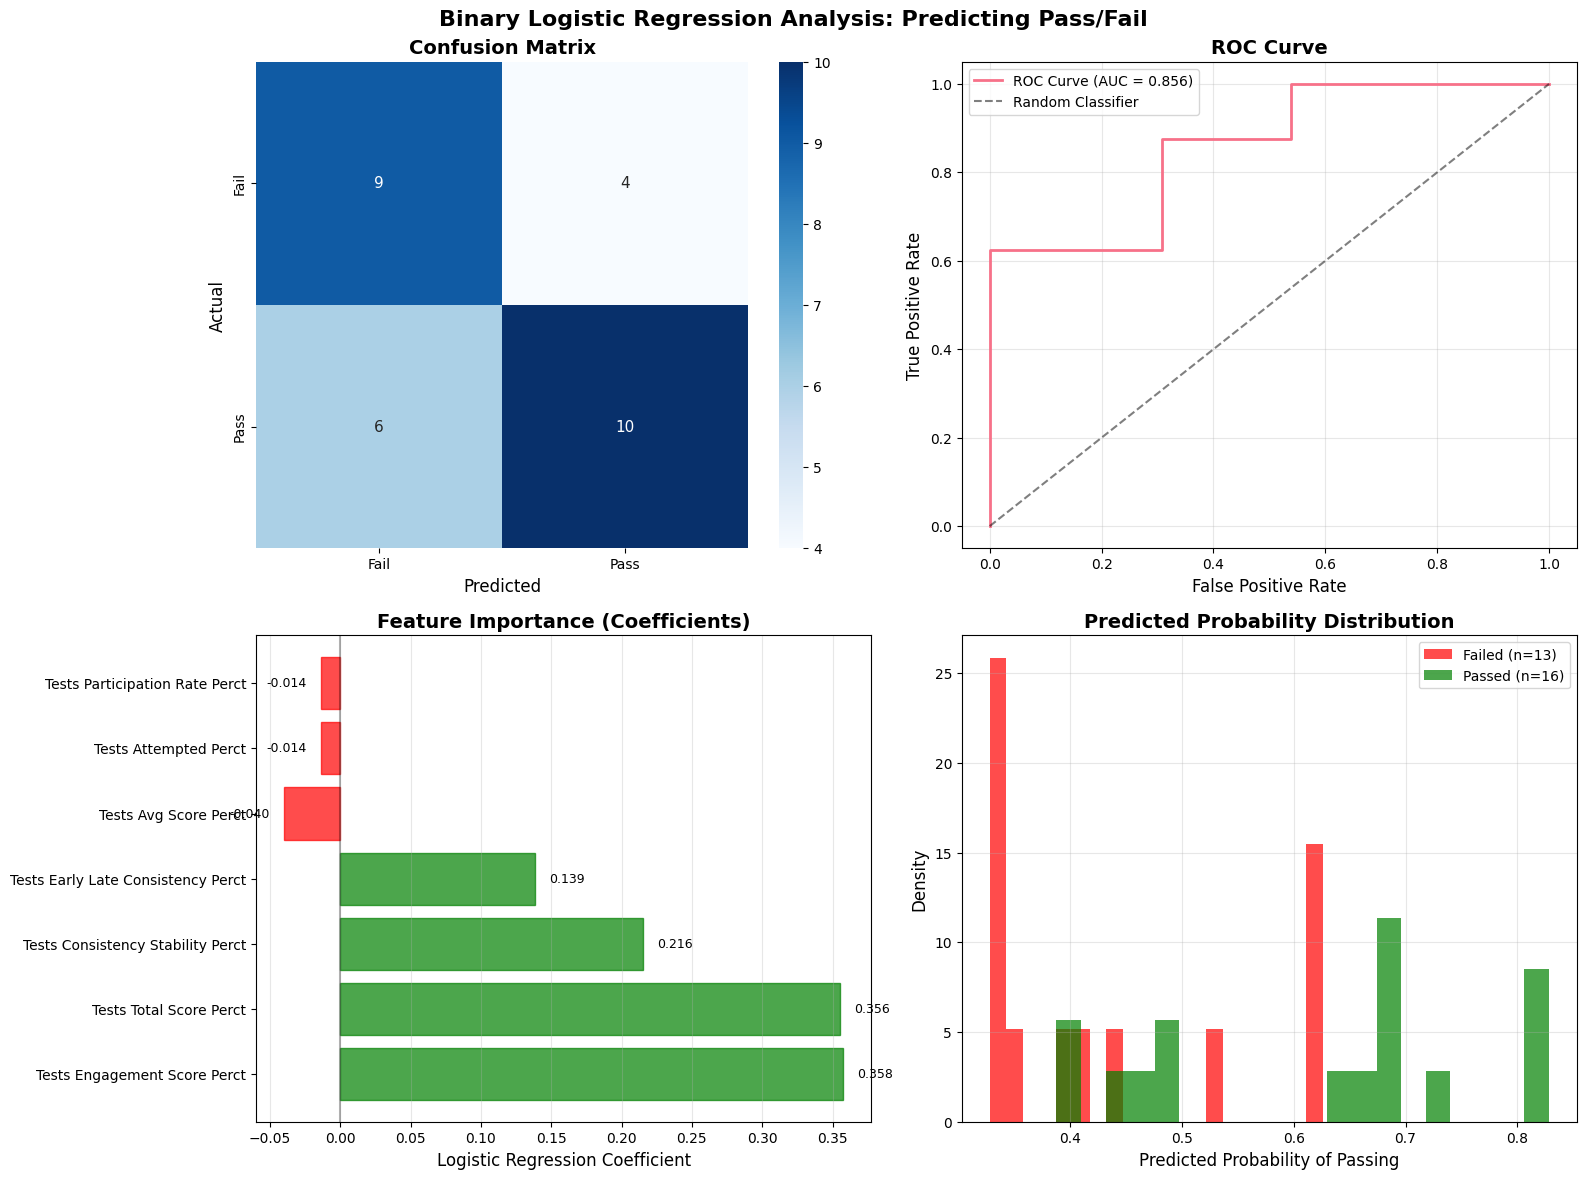


📋 DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

         0.0       0.60      0.69      0.64        13
         1.0       0.71      0.62      0.67        16

    accuracy                           0.66        29
   macro avg       0.66      0.66      0.65        29
weighted avg       0.66      0.66      0.66        29



In [7]:
def binary_logistic_regression_analysis(data, engagement_vars, target_var='passed'):
    """
    Focused binary logistic regression analysis for predicting pass/fail outcomes
    
    Parameters:
    -----------
    data : DataFrame - The dataset
    engagement_vars : list - List of engagement variable names  
    target_var : str - Target variable name (should be 'passed')
    
    Returns:
    --------
    dict - Dictionary containing model results, predictions, and evaluation metrics
    """
    from sklearn.linear_model import LogisticRegression
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
    from sklearn.metrics import (
        classification_report, confusion_matrix, roc_auc_score, roc_curve,
        accuracy_score, precision_score, recall_score, f1_score, log_loss
    )
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    print(f"\n{'='*80}")
    print(f"📊 BINARY LOGISTIC REGRESSION ANALYSIS: Predicting {target_var.upper()}")
    print(f"{'='*80}")
    
    # Check if target variable exists
    if target_var not in data.columns:
        print(f"❌ Target variable {target_var} not found in dataset")
        return None
    
    # Get available predictors
    available_predictors = [var for var in engagement_vars if var in data.columns]
    print(available_predictors)
    
    if not available_predictors:
        print("❌ No engagement predictors available")
        return None
    
    # Prepare data - remove rows with missing values
    analysis_vars = available_predictors + [target_var]
    clean_data = data[analysis_vars].dropna()
    
    if len(clean_data) < 20:
        print(f"❌ Insufficient data for logistic regression (n={len(clean_data)})")
        return None
    
    print(f"📊 Analysis dataset: {len(clean_data)} complete observations")
    print(f"Predictors: {available_predictors}")
    print(f"Target: {target_var}")
    
    # Prepare features and target
    X = clean_data[available_predictors]
    y = clean_data[target_var]
    
    # Display target distribution
    print(f"📈 Target distribution: {y.value_counts()}")
    print(f"📈 Class balance: {y.mean()*100:.1f}% positive class (passed)")
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    feature_names = X.columns.tolist()
    
    # Split data with stratified sampling
    test_size = 0.2
    random_state = 42
    
    print(f"\n🎯 STRATIFIED SAMPLING FOR CONSISTENT CLASS DISTRIBUTIONS")
    print("="*60)
    
    try:
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y, test_size=test_size, random_state=random_state, stratify=y
        )
        print(f"✅ Successfully applied stratified sampling")
        
        # Display class distributions in train/test splits
        train_dist = pd.Series(y_train).value_counts().sort_index()
        test_dist = pd.Series(y_test).value_counts().sort_index()
        overall_dist = pd.Series(y).value_counts().sort_index()
        
        print(f"Overall distribution: Fail={overall_dist.get(0,0)} ({overall_dist.get(0,0)/len(y)*100:.1f}%), Pass={overall_dist.get(1,0)} ({overall_dist.get(1,0)/len(y)*100:.1f}%)")
        print(f"Training set: Fail={train_dist.get(0,0)} ({train_dist.get(0,0)/len(y_train)*100:.1f}%), Pass={train_dist.get(1,0)} ({train_dist.get(1,0)/len(y_train)*100:.1f}%)")
        print(f"Test set: Fail={test_dist.get(0,0)} ({test_dist.get(0,0)/len(y_test)*100:.1f}%), Pass={test_dist.get(1,0)} ({test_dist.get(1,0)/len(y_test)*100:.1f}%)")
        
    except ValueError as e:
        print(f"⚠️ Stratification failed: {e}")
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y, test_size=test_size, random_state=random_state
        )
        
        # Still show distribution for random sampling
        train_dist = pd.Series(y_train).value_counts().sort_index()
        test_dist = pd.Series(y_test).value_counts().sort_index()
        print(f"Training set (random): Fail={train_dist.get(0,0)}, Pass={train_dist.get(1,0)}")
        print(f"Test set (random): Fail={test_dist.get(0,0)}, Pass={test_dist.get(1,0)}")
    
    # Train binary logistic regression model
    model = LogisticRegression(random_state=random_state, max_iter=1000)
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_scaled, y, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state), scoring='roc_auc')
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    try:
        auc_score = roc_auc_score(y_test, y_pred_proba)
    except:
        auc_score = np.nan
    
    print(f"\n🎯 BINARY LOGISTIC REGRESSION RESULTS:")
    print(f"{'='*60}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC-ROC: {auc_score:.4f}")
    print(f"Cross-validation AUC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    
    # Feature importance (coefficients)
    print(f"\n📊 FEATURE IMPORTANCE (Logistic Regression Coefficients):")
    print(f"{'='*70}")
    
    coefficients = model.coef_[0]
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients,
        'Abs_Coefficient': np.abs(coefficients),
        'Odds_Ratio': np.exp(coefficients)
    }).sort_values('Abs_Coefficient', ascending=False)
    
    print(feature_importance.round(4).to_string(index=False))
    
    print(f"\n💡 COEFFICIENT INTERPRETATION:")
    print(f"Positive coefficients increase the odds of success (passing)")
    print(f"Negative coefficients decrease the odds of success")
    print(f"Odds ratios > 1 indicate positive association, < 1 indicate negative association")
    
    # Create visualizations - 2x2 subplot for binary classification
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,0],
                xticklabels=['Fail', 'Pass'], yticklabels=['Fail', 'Pass'])
    axes[0,0].set_title('Confusion Matrix', fontweight='bold')
    axes[0,0].set_xlabel('Predicted')
    axes[0,0].set_ylabel('Actual')
    
    # 2. ROC Curve
    if not np.isnan(auc_score):
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        axes[0,1].plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {auc_score:.3f})')
        axes[0,1].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')
        axes[0,1].set_xlabel('False Positive Rate')
        axes[0,1].set_ylabel('True Positive Rate')
        axes[0,1].set_title('ROC Curve', fontweight='bold')
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)
    
    # 3. Feature Importance
    top_features = feature_importance.head(min(10, len(feature_importance)))
    bars = axes[1,0].barh(range(len(top_features)), top_features['Coefficient'])
    
    # Color bars based on sign
    for i, (bar, coef) in enumerate(zip(bars, top_features['Coefficient'])):
        bar.set_color('green' if coef > 0 else 'red')
        bar.set_alpha(0.7)
    
    axes[1,0].set_yticks(range(len(top_features)))
    axes[1,0].set_yticklabels([name.replace('_', ' ').title() for name in top_features['Feature']])
    axes[1,0].set_xlabel('Logistic Regression Coefficient')
    axes[1,0].set_title('Feature Importance (Coefficients)', fontweight='bold')
    axes[1,0].axvline(x=0, color='black', linestyle='-', alpha=0.3)
    axes[1,0].grid(True, alpha=0.3, axis='x')
    
    # Add coefficient values as text
    for i, (idx, row) in enumerate(top_features.iterrows()):
        coef_val = row['Coefficient']
        axes[1,0].text(coef_val + 0.01 if coef_val > 0 else coef_val - 0.01, i, 
                      f'{coef_val:.3f}', va='center', 
                      ha='left' if coef_val > 0 else 'right', fontsize=9)
    
    # 4. Probability Distribution
    # Show probability distributions for each class
    passed_probs = y_pred_proba[y_test == 1]
    failed_probs = y_pred_proba[y_test == 0]
    
    axes[1,1].hist(failed_probs, bins=20, alpha=0.7, label=f'Failed (n={len(failed_probs)})', 
                  color='red', density=True)
    axes[1,1].hist(passed_probs, bins=20, alpha=0.7, label=f'Passed (n={len(passed_probs)})', 
                  color='green', density=True)
    axes[1,1].set_xlabel('Predicted Probability of Passing')
    axes[1,1].set_ylabel('Density')
    axes[1,1].set_title('Predicted Probability Distribution', fontweight='bold')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    plt.suptitle('Binary Logistic Regression Analysis: Predicting Pass/Fail', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Classification Report
    print(f"\n📋 DETAILED CLASSIFICATION REPORT:")
    print(f"{'='*60}")
    print(classification_report(y_test, y_pred))
    
    # Return results
    results = {
        'model': model,
        'scaler': scaler,
        'feature_names': feature_names,
        'y_test': y_test,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'cv_scores': cv_scores,
        'auc_score': auc_score,
        'feature_importance': feature_importance
    }
    
    return results


# Run binary logistic regression to predict pass/fail
print("🎯 Running Binary Logistic Regression to predict PASS/FAIL...")
print("="*60)
binary_results = binary_logistic_regression_analysis(
    data=df, 
    engagement_vars=sorted([metric for metric in engagement_metrics if metric.endswith("_perct")]), 
    target_var='passed'
)

In [8]:
# Model Insights and Summary
print("\n" + "="*80)
print("📊 BINARY LOGISTIC REGRESSION INSIGHTS")
print("="*80)

if binary_results is not None:
    
    print(f"\n🎯 MODEL PERFORMANCE SUMMARY:")
    print(f"{'='*50}")
    
    print(f"Binary Classification (Pass/Fail):")
    print(f"  • Accuracy: {binary_results['accuracy']:.4f}")
    print(f"  • AUC-ROC: {binary_results['auc_score']:.4f}")
    print(f"  • F1-Score: {binary_results['f1_score']:.4f}")
    print(f"  • Precision: {binary_results['precision']:.4f}")
    print(f"  • Recall: {binary_results['recall']:.4f}")
    print(f"  • CV AUC: {binary_results['cv_scores'].mean():.4f} ± {binary_results['cv_scores'].std():.4f}")
    
    # Feature importance analysis
    print(f"\n🏆 TOP PREDICTIVE FEATURES:")
    print(f"{'='*50}")
    
    if 'feature_importance' in binary_results:
        top_features = binary_results['feature_importance'].head(3)
        print(f"\nTop 3 Features for Pass/Fail Prediction:")
        for idx, row in top_features.iterrows():
            direction = "increases" if row['Coefficient'] > 0 else "decreases"
            print(f"  • {row['Feature'].replace('_', ' ').title()}: {direction} odds by {abs(row['Coefficient']):.3f}")
            print(f"    (Odds Ratio: {row['Odds_Ratio']:.3f})")
    
    # Model reliability assessment
    print(f"\n💡 MODEL RELIABILITY ASSESSMENT:")
    print(f"{'='*50}")
    
    auc_score = binary_results['auc_score']
    accuracy = binary_results['accuracy']
    
    print(f"AUC-ROC Interpretation:")
    if auc_score >= 0.9:
        print(f"  ✅ Excellent discrimination (AUC = {auc_score:.3f}) - Outstanding model")
    elif auc_score >= 0.8:
        print(f"  ✅ Good discrimination (AUC = {auc_score:.3f}) - Good model")
    elif auc_score >= 0.7:
        print(f"  🔶 Fair discrimination (AUC = {auc_score:.3f}) - Acceptable model")
    elif auc_score >= 0.6:
        print(f"  ⚠️ Poor discrimination (AUC = {auc_score:.3f}) - Limited usefulness")
    else:
        print(f"  ❌ Very poor discrimination (AUC = {auc_score:.3f}) - Not useful")
    
    print(f"\nAccuracy Interpretation:")
    if accuracy >= 0.8:
        print(f"  ✅ High accuracy ({accuracy:.3f}) - Very reliable predictions")
    elif accuracy >= 0.7:
        print(f"  🔶 Good accuracy ({accuracy:.3f}) - Reliable predictions")
    elif accuracy >= 0.6:
        print(f"  ⚠️ Moderate accuracy ({accuracy:.3f}) - Use with caution")
    else:
        print(f"  ❌ Low accuracy ({accuracy:.3f}) - Poor reliability")
    
    # Cross-validation stability
    cv_mean = binary_results['cv_scores'].mean()
    cv_std = binary_results['cv_scores'].std()
    
    print(f"\nCross-Validation Stability:")
    if cv_std < 0.05:
        print(f"  ✅ Very stable (CV AUC: {cv_mean:.3f} ± {cv_std:.3f})")
    elif cv_std < 0.1:
        print(f"  🔶 Moderately stable (CV AUC: {cv_mean:.3f} ± {cv_std:.3f})")
    else:
        print(f"  ⚠️ Unstable (CV AUC: {cv_mean:.3f} ± {cv_std:.3f})")
    
    # Practical insights
    print(f"\n🎯 PRACTICAL INSIGHTS:")
    print(f"{'='*50}")
    
    print(f"Early Warning System:")
    print(f"  • Model can identify at-risk students with {accuracy*100:.1f}% accuracy")
    print(f"  • AUC of {auc_score:.3f} indicates {'good' if auc_score >= 0.8 else 'moderate' if auc_score >= 0.7 else 'limited'} discrimination ability")
    print(f"  • Can be used for timely academic interventions")
    
    print(f"\nEngagement Patterns:")
    if 'feature_importance' in binary_results:
        top_feature = binary_results['feature_importance'].iloc[0]
        print(f"  • Most important predictor: {top_feature['Feature'].replace('_', ' ').title()}")
        print(f"  • Focus intervention strategies on improving {top_feature['Feature'].replace('_', ' ').lower()}")
    
    print(f"\nRecommendations:")
    print(f"  • Use model for early identification of at-risk students")
    print(f"  • Implement interventions based on top predictive features")
    print(f"  • Monitor engagement metrics regularly throughout the semester")
    if auc_score >= 0.8:
        print(f"  • Model is reliable enough for operational use")
    else:
        print(f"  • Consider collecting additional features to improve model performance")

else:
    print("❌ Unable to provide insights - binary analysis failed")



📊 BINARY LOGISTIC REGRESSION INSIGHTS

🎯 MODEL PERFORMANCE SUMMARY:
Binary Classification (Pass/Fail):
  • Accuracy: 0.6552
  • AUC-ROC: 0.8558
  • F1-Score: 0.6560
  • Precision: 0.6631
  • Recall: 0.6552
  • CV AUC: 0.6705 ± 0.0735

🏆 TOP PREDICTIVE FEATURES:

Top 3 Features for Pass/Fail Prediction:
  • Tests Engagement Score Perct: increases odds by 0.358
    (Odds Ratio: 1.430)
  • Tests Total Score Perct: increases odds by 0.356
    (Odds Ratio: 1.427)
  • Tests Consistency Stability Perct: increases odds by 0.216
    (Odds Ratio: 1.240)

💡 MODEL RELIABILITY ASSESSMENT:
AUC-ROC Interpretation:
  ✅ Good discrimination (AUC = 0.856) - Good model

Accuracy Interpretation:
  ⚠️ Moderate accuracy (0.655) - Use with caution

Cross-Validation Stability:
  🔶 Moderately stable (CV AUC: 0.670 ± 0.074)

🎯 PRACTICAL INSIGHTS:
Early Warning System:
  • Model can identify at-risk students with 65.5% accuracy
  • AUC of 0.856 indicates good discrimination ability
  • Can be used for timely aca

🎯 Running Binary Model Validation Analysis...

📊 BINARY MODEL VALIDATION ANALYSIS
📊 Validation dataset: 142 complete observations
📊 Computing learning curves...
📊 Computing validation curves for regularization...
📊 Computing cross-validation score distribution...


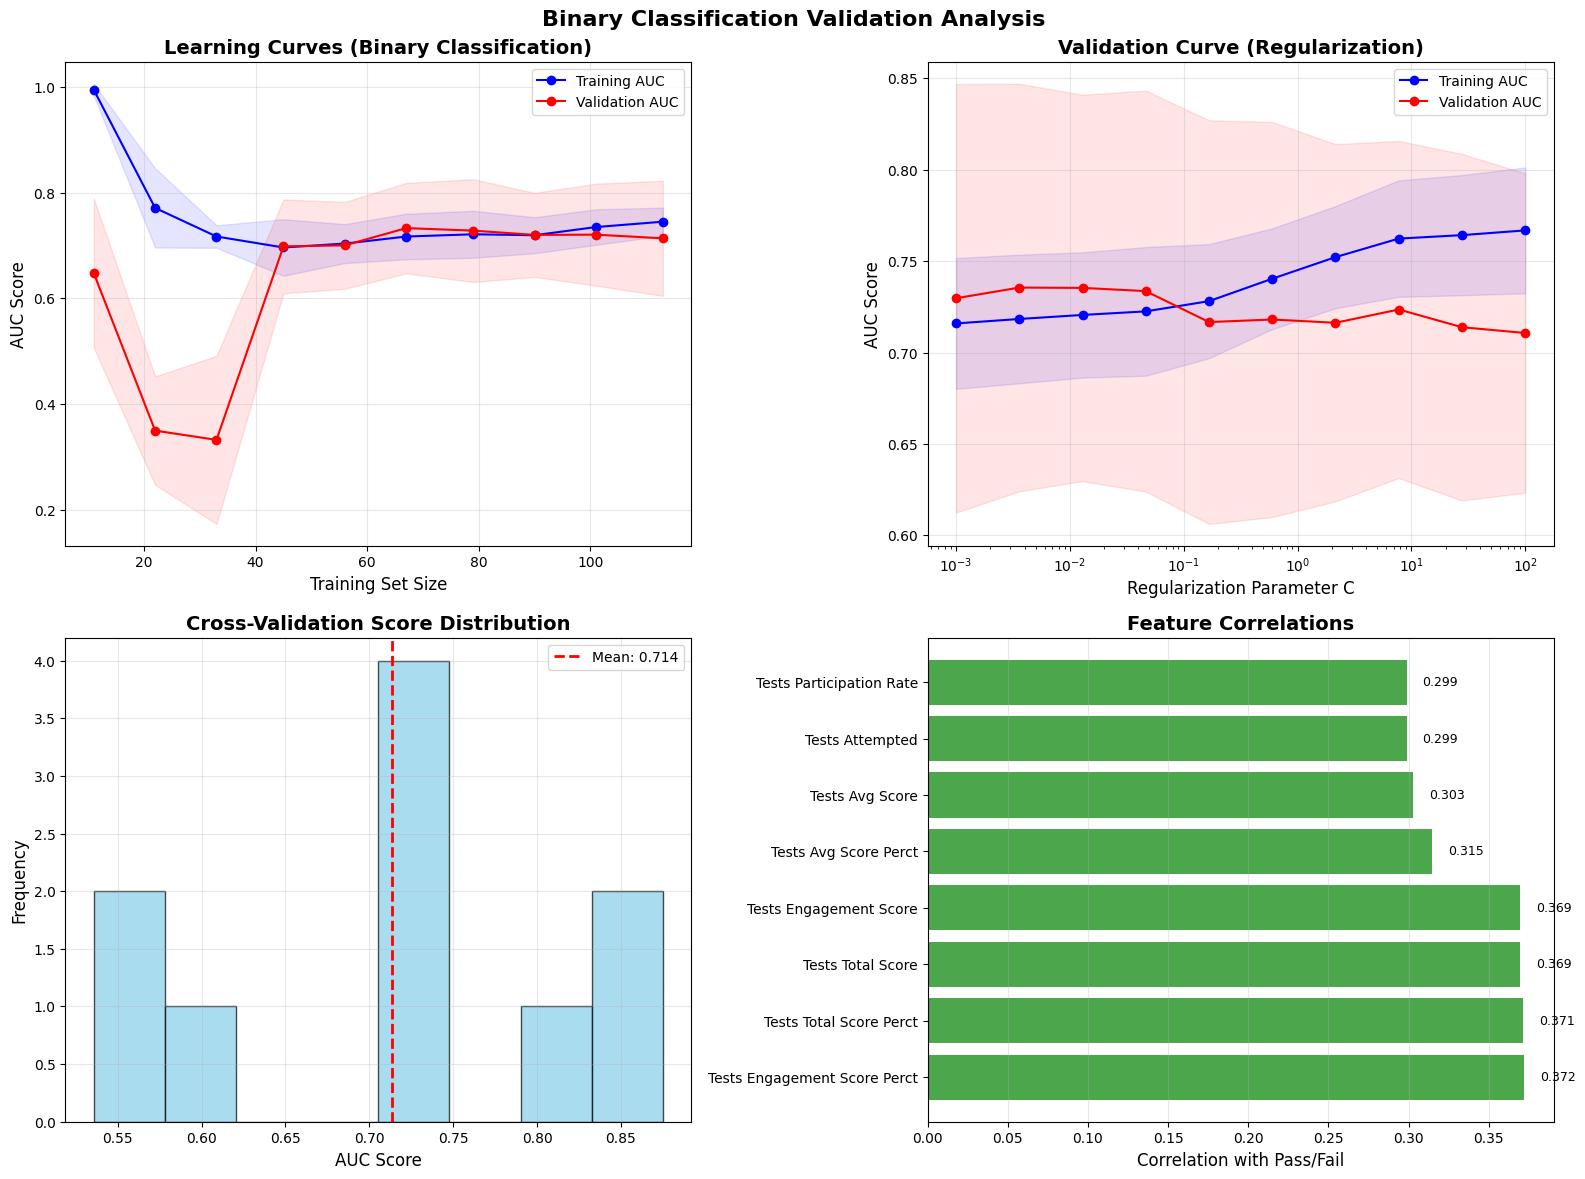


📊 VALIDATION DIAGNOSTICS:
Learning curve final gap: 0.0561
🔶 Moderate gap - acceptable

Best regularization C: 0.004
CV score stability (std): 0.1111
⚠️ Unstable cross-validation


In [9]:
# Binary-only validation analysis
def plot_binary_learning_curves_and_validation(data, engagement_vars, target_var='passed'):
    """
    Plot learning curves and validation error for binary classification only
    """
    from sklearn.model_selection import learning_curve, validation_curve
    from sklearn.linear_model import LogisticRegression
    from sklearn.preprocessing import StandardScaler
    import matplotlib.pyplot as plt
    import numpy as np
    
    print(f"\n{'='*80}")
    print(f"📊 BINARY MODEL VALIDATION ANALYSIS")
    print(f"{'='*80}")
    
    # Get available predictors
    available_predictors = [var for var in engagement_vars if var in data.columns]
    
    if not available_predictors or target_var not in data.columns:
        print("❌ Insufficient variables for validation analysis")
        return None
    
    # Prepare clean data
    analysis_vars = available_predictors + [target_var]
    clean_data = data[analysis_vars].dropna()
    
    if len(clean_data) < 30:
        print(f"❌ Insufficient data for validation analysis (n={len(clean_data)})")
        return None
    
    print(f"📊 Validation dataset: {len(clean_data)} complete observations")
    
    # Prepare features and target
    X = clean_data[available_predictors]
    y = clean_data[target_var]
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Create model
    model = LogisticRegression(random_state=42, max_iter=1000)
    
    # Create figure with 2x2 subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Learning Curves
    print("📊 Computing learning curves...")
    train_sizes, train_scores, val_scores = learning_curve(
        model, X_scaled, y, cv=5, n_jobs=1, 
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='roc_auc'
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    axes[0,0].plot(train_sizes, train_mean, 'o-', color='blue', label='Training AUC')
    axes[0,0].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
    axes[0,0].plot(train_sizes, val_mean, 'o-', color='red', label='Validation AUC')
    axes[0,0].fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')
    axes[0,0].set_xlabel('Training Set Size')
    axes[0,0].set_ylabel('AUC Score')
    axes[0,0].set_title('Learning Curves (Binary Classification)', fontweight='bold')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Validation Curves for Regularization
    print("📊 Computing validation curves for regularization...")
    C_range = np.logspace(-3, 2, 10)
    train_scores, val_scores = validation_curve(
        LogisticRegression(random_state=42, max_iter=1000), 
        X_scaled, y, param_name='C', param_range=C_range, cv=5, scoring='roc_auc'
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    axes[0,1].semilogx(C_range, train_mean, 'o-', color='blue', label='Training AUC')
    axes[0,1].fill_between(C_range, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
    axes[0,1].semilogx(C_range, val_mean, 'o-', color='red', label='Validation AUC')
    axes[0,1].fill_between(C_range, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')
    axes[0,1].set_xlabel('Regularization Parameter C')
    axes[0,1].set_ylabel('AUC Score')
    axes[0,1].set_title('Validation Curve (Regularization)', fontweight='bold')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Cross-validation score distribution
    print("📊 Computing cross-validation score distribution...")
    from sklearn.model_selection import cross_val_score
    cv_scores = cross_val_score(model, X_scaled, y, cv=10, scoring='roc_auc')
    
    axes[1,0].hist(cv_scores, bins=8, alpha=0.7, color='skyblue', edgecolor='black')
    axes[1,0].axvline(cv_scores.mean(), color='red', linestyle='--', linewidth=2, 
                     label=f'Mean: {cv_scores.mean():.3f}')
    axes[1,0].set_xlabel('AUC Score')
    axes[1,0].set_ylabel('Frequency')
    axes[1,0].set_title('Cross-Validation Score Distribution', fontweight='bold')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # 4. Feature correlation with target
    correlations = []
    for feature in available_predictors:
        if feature in clean_data.columns:
            corr = clean_data[feature].corr(clean_data[target_var])
            correlations.append((feature.replace('_', ' ').title(), corr))
    
    correlations.sort(key=lambda x: abs(x[1]), reverse=True)
    features, corrs = zip(*correlations[:8])  # Top 8 features
    
    colors = ['green' if c > 0 else 'red' for c in corrs]
    bars = axes[1,1].barh(range(len(features)), corrs, color=colors, alpha=0.7)
    axes[1,1].set_yticks(range(len(features)))
    axes[1,1].set_yticklabels(features)
    axes[1,1].set_xlabel('Correlation with Pass/Fail')
    axes[1,1].set_title('Feature Correlations', fontweight='bold')
    axes[1,1].axvline(x=0, color='black', linestyle='-', alpha=0.3)
    axes[1,1].grid(True, alpha=0.3, axis='x')
    
    # Add correlation values as text
    for i, (bar, corr) in enumerate(zip(bars, corrs)):
        axes[1,1].text(corr + 0.01 if corr > 0 else corr - 0.01, i, 
                      f'{corr:.3f}', va='center', 
                      ha='left' if corr > 0 else 'right', fontsize=9)
    
    plt.suptitle('Binary Classification Validation Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Diagnostic information
    print(f"\n📊 VALIDATION DIAGNOSTICS:")
    print(f"{'='*60}")
    print(f"Learning curve final gap: {train_mean[-1] - val_mean[-1]:.4f}")
    if train_mean[-1] - val_mean[-1] > 0.1:
        print("⚠️  Large gap suggests overfitting")
    elif train_mean[-1] - val_mean[-1] < 0.02:
        print("✅ Small gap suggests good generalization")
    else:
        print("🔶 Moderate gap - acceptable")
    
    print(f"\nBest regularization C: {C_range[np.argmax(val_mean)]:.3f}")
    print(f"CV score stability (std): {cv_scores.std():.4f}")
    
    if cv_scores.std() < 0.05:
        print("✅ Very stable cross-validation")
    elif cv_scores.std() < 0.1:
        print("🔶 Moderately stable cross-validation")
    else:
        print("⚠️ Unstable cross-validation")
    
    return {
        'learning_curves': (train_sizes, train_scores, val_scores),
        'validation_curves': (C_range, train_scores, val_scores),
        'cv_scores': cv_scores,
        'correlations': correlations
    }

# Run validation analysis for binary model
if binary_results is not None:
    print("🎯 Running Binary Model Validation Analysis...")
    binary_validation = plot_binary_learning_curves_and_validation(
        df, engagement_metrics, 'passed'
    )
else:
    print("❌ Need binary results to run validation analysis")